In [1]:
from laplace.baselaplace import FullLaplace
from laplace.curvature.backpack import BackPackGGN
import numpy as np
import torch

from laplace import Laplace, marglik_training
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
import h5py

In [2]:
torch.manual_seed(42)  # for reproducibility

def generate_data(N=2000, test_ratio=0.5):
    # Calculate sizes
    test_size = int(N * test_ratio)
    train_size = N - test_size
    
    # Generate x for training data ensuring no points between -1 and 0
    train_x = torch.empty(train_size, 1)
    idx = 0
    while idx < train_size:
        sample = torch.rand(1) * 12 - 6
        if sample <= -1 or sample >= 0:
            train_x[idx] = sample
            idx += 1
    
    # Generate x for test data without any restrictions
    test_x = torch.rand(test_size) * 12 - 6
    test_x = torch.unsqueeze(test_x, dim=1)
    
    # Concatenate training and test x values
    x = torch.cat((train_x, test_x), 0)
    
    # Calculate y values for entire dataset
    y = 2 * torch.sin(x) + 0.1 * x.pow(2) + torch.normal(0, 0.7, size=(N, 1))
    
    # Shuffle the data
    indices = torch.randperm(N)
    shuffled_x = x[indices]
    shuffled_y = y[indices]
    
    # Split data into training and test sets
    train_x = shuffled_x[:train_size]
    train_y = shuffled_y[:train_size]
    test_x = shuffled_x[train_size:]
    test_y = shuffled_y[train_size:]
    
    return test_x, test_y, train_x, train_y

# Neural network definition
class ExtendedNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(ExtendedNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Train the model function
def train_model(model, data_loader, criterion, optimizer, num_epochs=1000):
    losses = []
    for epoch in range(num_epochs):
        for inputs, targets in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch+1) % 100 == 0:
            losses.append(loss.item())
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    return losses

test_x, test_y, train_x, train_y = generate_data(N=2000, test_ratio=0.3)

# Create DataLoader for training data
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

input_dim = 1
hidden_dim1 = 15
hidden_dim2 = 5
output_dim = 1
model = ExtendedNN(input_dim, hidden_dim1, hidden_dim2, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

losses = train_model(model, train_loader, criterion, optimizer, num_epochs=5000)

# Plot the loss curve
plt.plot(losses)
plt.xlabel('Epoch (in hundreds)')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

# Test the model
model.eval()  # set the model to evaluation mode
with torch.no_grad():
    test_outputs = model(test_x)
    
plt.scatter(test_x, test_y, label='True Data', s=5)
plt.scatter(test_x, test_outputs, color='red', label='Predictions', s=5)
plt.legend()
plt.title('Regression Results')
plt.show()

Epoch [100/5000], Loss: 0.5866
Epoch [200/5000], Loss: 0.4972


KeyboardInterrupt: 

# Testing the laplace API from Alex Immer

## Fitting and optimizing the Laplace approximation using empirical Bayes

In [3]:
la = Laplace(model, 'regression', subset_of_weights='all', hessian_structure='full')
la.fit(train_loader)
log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
n_epochs = 10000
for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

/Users/noahliniger/opt/miniconda3/envs/dslab/lib/python3.9/site-packages/backpack/extensions/backprop_extension.py:106: UserWarning: Extension saving to grad_batch does not have an extension for Module <class '__main__.ExtendedNN'> although the module has parameters
  warnings.warn(


In [4]:
x = test_x.flatten().cpu().numpy()
f_mu, f_var = la(test_x)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

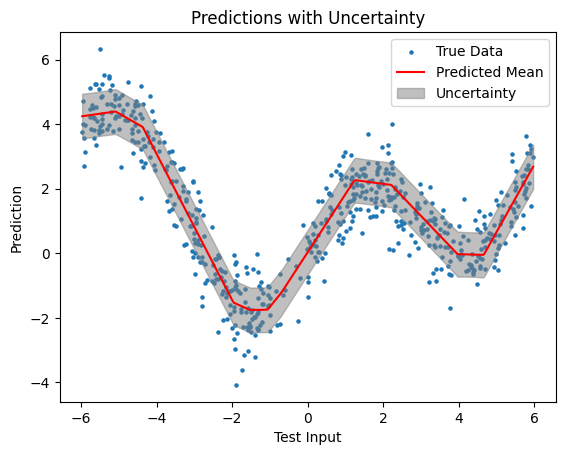

In [5]:
# Order x and apply the same ordering to f_mu and pred_std
order = np.argsort(x)
x = x[order]
f_mu = f_mu[order]
pred_std = pred_std[order]

plt.scatter(test_x, test_y, label='True Data', s=5)
plt.plot(x, f_mu, 'r-', label="Predicted Mean")
plt.fill_between(x, f_mu - pred_std, f_mu + pred_std, color='gray', alpha=0.5, label="Uncertainty")

plt.xlabel("Test Input")
plt.ylabel("Prediction")
plt.title("Predictions with Uncertainty")
plt.legend()
plt.show()

## Marginal likelyhood training

In [6]:
test_x, test_y, train_x, train_y = generate_data(N=3000, test_ratio=0.5)
model2 = ExtendedNN(input_dim, hidden_dim1, hidden_dim2, output_dim)

train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

x_t = torch.vstack(tensors=(test_x, train_x))
y_t = torch.vstack(tensors=(test_y, train_y))
x_t, sorted_indices = test_x.sort(dim=0)
y_t = y_t[sorted_indices.squeeze()]

In [7]:
la, model, margliks, losses = marglik_training(
    model=model2, train_loader=train_loader, likelihood='regression',
    hessian_structure='full', backend=BackPackGGN, n_epochs=1000, 
    optimizer_kwargs={'lr': 1e-3}, prior_structure='scalar'
)

In [8]:
f_mu, f_var = la(x_t)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

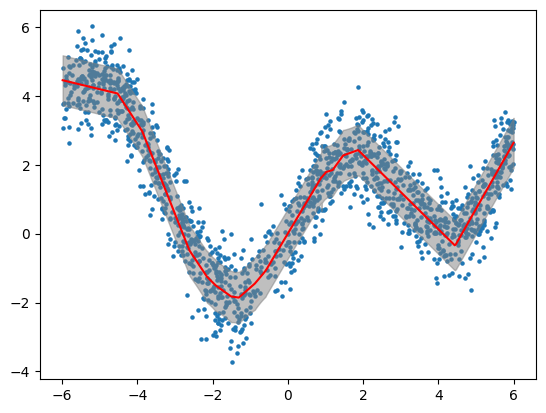

In [9]:
plt.scatter(x_t.squeeze(), y_t.squeeze(), label='True Data', s=5)
plt.plot(x_t.squeeze(), f_mu, 'r-', label="Predicted Mean")
plt.fill_between(x_t.squeeze(), f_mu - pred_std, f_mu + pred_std, color='gray', alpha=0.5, label="Uncertainty")

# Training test:

In [ ]:
from WaveformDataset import WaveformDataset
from torch.utils.data import ConcatDataset, DataLoader


csv_files = ['..//data//chunk2.csv']#, '..//data//chunk3.csv', '..//data//chunk4.csv']
h5_files = ['..//data//chunk2.hdf5']#, '..//data//chunk3.hdf5', '..//data//chunk4.hdf5']

datasets = [WaveformDataset(csv_file=csv_files[i], h5_file=h5_files[i]) for i in range(len(csv_files))]

# Concatenate the datasets
concatenated_dataset = ConcatDataset(datasets)

# Now you can use the concatenated dataset with a DataLoader
print("creating dataloader")
dataloader = DataLoader(concatenated_dataset, batch_size=64, shuffle=True, num_workers=4)

# Preprocessing tests

In [70]:
from WaveformDataset import WaveformDataset
from torch.utils.data import ConcatDataset, DataLoader


# h5_file = '..//data//chunk3.hdf5'
# dataset = WaveformDataset(csv_file=csv_file, h5_file=h5_file)

csv_files = ['..//data//chunk2.csv']#, '..//data//chunk3.csv', '..//data//chunk4.csv']
h5_files = ['..//data//chunk2.hdf5']#, '..//data//chunk3.hdf5', '..//data//chunk4.hdf5']

datasets = [WaveformDataset(csv_file=csv_files[i], h5_file=h5_files[i]) for i in range(len(csv_files))]

# Concatenate the datasets
concatenated_dataset = ConcatDataset(datasets)

# Now you can use the concatenated dataset with a DataLoader
print("creating dataloader")
dataloader = DataLoader(concatenated_dataset, batch_size=64, shuffle=True, num_workers=4)

FileNotFoundError: [Errno 2] No such file or directory: '..//data//chunk2.csv'

In [18]:
from torch.nn import MaxPool1d
from torch.nn import Conv1d
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Flatten
from torch.nn import BatchNorm1d
from torch.nn import Sequential
import torch

class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int,\
        padding: int, bn_num_features: int, eps: float = 1e-5, momentum: float = 0.1,\
        mp_kernel_size: int = 10, stride: int = 3) -> None:
        super().__init__()
        self.convSequential = Sequential(
            Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding),
            ReLU(),
            BatchNorm1d(num_features=bn_num_features, eps=eps, momentum=momentum),
            MaxPool1d(kernel_size=mp_kernel_size, stride=stride)
        )
    
    def forward(self, x):
        return self.convSequential(x)

class LinearBlock(torch.nn.Module):
    def __init__(self, in_features: int, out_features: int, eps: float = 1e-5, momentum : float = 0.1):
        super().__init__()
        self.linearSequential = Sequential(
            Linear(in_features=in_features, out_features=out_features),
            ReLU(),
            BatchNorm1d(num_features=out_features, eps=eps, momentum=momentum)
        )
    def forward(self, x):
        return self.linearSequential(x)


class CNNNet(torch.nn.Module):
    def __init__(self, num_channels=1):
        super(CNNNet, self).__init__()
        filter1 = 21
        filter2 = 15
        filter3 = 9
        filter4 = 5
        flattened = 23392
        linear1 = 256
        linear2 = 128
        linearOut = 2

        self.convBlock1 = ConvBlock(in_channels=1, out_channels=32,\
                                    kernel_size=filter1, padding=filter1//2,bn_num_features=32)
        self.convBlock2 = ConvBlock(in_channels=32, out_channels=64,\
                                    kernel_size=filter2, padding=filter2//2,bn_num_features=32)
        self.convBlock3 = ConvBlock(in_channels=64, out_channels=138,\
                                    kernel_size=filter3, padding=filter3//2,bn_num_features=32)
        self.fcBlock1 = LinearBlock(in_features=flattened, out_features=linear1)
        self.fcBlock2 = LinearBlock(in_features=linear1, out_features=linear2)
        self.regression = Linear(in_features=linear2, out_features=linearOut)

    def forward(self, x):
        x = self.convBlock1(x)
        x = self.convBlock2(x)
        x = self.convBlock3(x)
        x = self.fcBlock1(x)
        x = self.fcBlock2(x)
        return self.regression(x)

net = CNNNet()

dataloader = DataLoader(concatenated_dataset, batch_size=64, shuffle=True, num_workers=4)

for signals, labels, snrs in dataloader: break

signals = signals.reshape(64,1,-1)

net(signals)

RuntimeError: running_mean should contain 64 elements not 32

In [39]:
from torch.nn import MaxPool1d
from torch.nn import Conv1d
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Flatten

class CNNNet(torch.nn.Module):
    def __init__(self, num_channels=1):
        super(CNNNet, self).__init__()
        self.relu = ReLU()
        self.flatten = torch.nn.Flatten()
        filter1 = 21
        filter2 = 15
        filter3 = 9
        filter4 = 5
        linear_shape = 2208

        self.maxpool = MaxPool1d(kernel_size=10, stride=2)
        self.conv1 = Conv1d(num_channels, 32,
                            kernel_size=filter1, padding=filter1 // 2)
        self.bn1 = torch.nn.BatchNorm1d(32, eps=1e-05, momentum=0.1)

        self.conv2 = Conv1d(32, 32,
                            kernel_size=filter2, padding=filter2 // 2)
        self.bn2 = torch.nn.BatchNorm1d(32, eps=1e-05, momentum=0.1)

        self.conv3 = Conv1d(32, 32,
                            kernel_size=filter3, padding=filter3 // 2)
        self.bn3 = torch.nn.BatchNorm1d(32, eps=1e-05, momentum=0.1)

        self.conv4 = Conv1d(32, 32,
                            kernel_size=filter4, padding=filter4 // 2)
        self.bnFour = torch.nn.BatchNorm1d(32, eps=1e-05, momentum=0.1)

        self.fcn1 = Linear(linear_shape, 256)
        self.bn4 = torch.nn.BatchNorm1d(256, eps=1e-05, momentum=0.1)

        self.fcn2 = Linear(256, 128)
        self.bn5 = torch.nn.BatchNorm1d(128, eps=1e-05, momentum=0.1)

        self.fcn3 = Linear(128, 2)

    def forward(self, x):
        # N.B. Consensus seems to be growing that BN goes after nonlinearity
        # That's why this is different than Zach's original paper.
        # First convolutional layer
        print(x.shape)
        x = self.conv1(x)
        print(x.shape)
        x = self.relu(x)
        print(x.shape)
        x = self.bn1(x)
        print(x.shape)
        x = self.maxpool(x)
        print(x.shape)
        print("end of cblock 1")
        # Second convolutional layer
        x = self.conv2(x)
        print(x.shape)
        x = self.relu(x)
        print(x.shape)
        x = self.bn2(x)
        print(x.shape)
        x = self.maxpool(x)
        print(x.shape)
        print("end of cblock 2")
        # Third convolutional layer
        x = self.conv3(x)
        print(x.shape)
        x = self.relu(x)
        print(x.shape)
        x = self.bn3(x)
        print(x.shape)
        x = self.maxpool(x)
        print(x.shape)
        print("end of cblock 3")

        x = self.conv4(x)
        print(x.shape)
        x = self.relu(x)
        print(x.shape)
        x = self.bnFour(x)
        print(x.shape)
        x = self.maxpool(x)
        print(x.shape)
        print("end of cblock 4")

        # Flatten
        x = self.flatten(x)
        print(x.shape)
        # First fully connected layer
        x = self.fcn1(x)
        x = self.relu(x)
        x = self.bn4(x)
        print(x.shape)
        # Second fully connected layer
        x = self.fcn2(x)
        x = self.relu(x)
        x = self.bn5(x)
        print(x.shape)
        # Last layer
        x = self.fcn3(x)
        print(x.shape)
        return x

net = CNNNet()

dataloader = DataLoader(concatenated_dataset, batch_size=64, shuffle=True, num_workers=4)

for signals, labels, snrs in dataloader: break

signals = signals.reshape(64,1,-1)

net(signals)



/Users/noahliniger/Documents/GitHub/earthquake-monitoring/Regression/WaveformDataset.py:68: RuntimeWarning: invalid value encountered in divide
  return (data - data.min()) / (data.max() - data.min())


torch.Size([64, 1, 5900])
torch.Size([64, 32, 5900])
torch.Size([64, 32, 5900])
torch.Size([64, 32, 5900])
torch.Size([64, 32, 1964])
end of cblock 1
torch.Size([64, 32, 1964])
torch.Size([64, 32, 1964])
torch.Size([64, 32, 1964])
torch.Size([64, 32, 652])
end of cblock 2
torch.Size([64, 32, 652])
torch.Size([64, 32, 652])
torch.Size([64, 32, 652])
torch.Size([64, 32, 215])
end of cblock 3
torch.Size([64, 32, 215])
torch.Size([64, 32, 215])
torch.Size([64, 32, 215])
torch.Size([64, 32, 69])
end of cblock 4
torch.Size([64, 2208])
torch.Size([64, 256])
torch.Size([64, 128])
torch.Size([64, 2])


tensor([[-0.2854, -0.4704],
        [-0.5193,  0.0400],
        [-0.8316, -0.6900],
        [ 0.2612,  0.1673],
        [ 0.1544,  0.3496],
        [ 0.8097, -0.3710],
        [ 0.3733, -0.5281],
        [-0.3312, -0.5327],
        [ 0.3691,  0.1314],
        [ 0.1830,  0.1754],
        [-1.1616,  1.3704],
        [-0.4184,  0.0231],
        [ 0.6054, -0.2816],
        [-0.0118, -0.6913],
        [-0.3032, -0.6766],
        [ 0.6402, -0.2672],
        [-0.8471, -0.2407],
        [-0.4251, -0.7791],
        [-0.3742,  0.1081],
        [-0.6249, -0.1680],
        [ 0.5389, -0.2051],
        [ 1.2671, -0.3092],
        [-0.0928,  0.5364],
        [ 0.1830, -0.2462],
        [ 0.3613,  0.5393],
        [-0.2038, -0.5831],
        [ 0.1542, -0.5257],
        [-0.3033,  0.0604],
        [ 1.3626,  0.2164],
        [ 0.2887,  0.5535],
        [-0.0501,  0.6965],
        [-0.1510,  0.1342],
        [ 0.7130,  0.3422],
        [ 0.2406, -0.1314],
        [ 0.0565,  0.8187],
        [ 0.0117, -0

In [38]:
sum(p.numel() for p in net.parameters())

630178

In [15]:
5890/2

2945.0

In [11]:
9//2

4

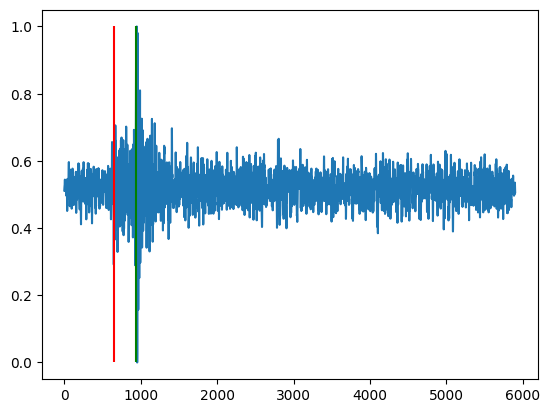

In [16]:
all_labels = []
from tqdm import tqdm

# Iterate over your DataLoader to collect all labels
# for _, labels, _ in tqdm(dataloader):
#     # Labels are expected to be a batch of tensors, so they need to be concatenated
#     all_labels.append(labels)

for series, labels, _ in dataloader:
    # Labels are expected to be a batch of tensors, so they need to be concatenated
    plt.plot(series[0,:])
    plt.vlines(labels[0,0], ymin=0, ymax=1, colors='r')
    plt.vlines(labels[0,1], ymin=0, ymax=1, colors='g')
    break

1

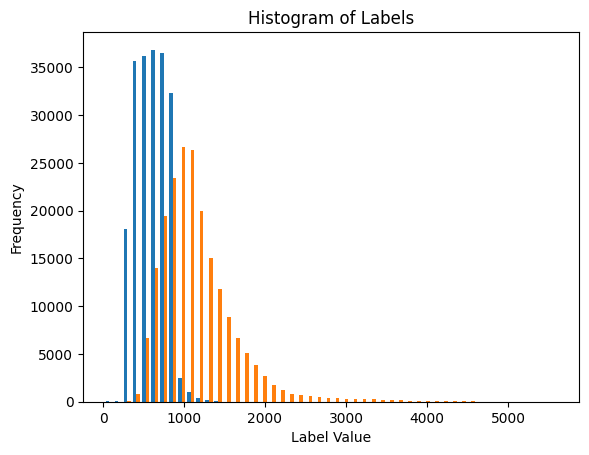

In [ ]:
# Now you have a list of batches, you need to concatenate them into a single tensor
all_labels = torch.cat(all_labels, dim=0)

# Convert to a NumPy array for plotting
all_labels = all_labels.numpy()

# Assuming each label is a scalar, you can plot a histogram directly.
# If labels are multi-dimensional, you'll need to adjust this accordingly.
plt.hist(all_labels, bins=50)  # Adjust the number of bins as needed
plt.xlabel('Label Value')
plt.ylabel('Frequency')
plt.title('Histogram of Labels')
plt.show()

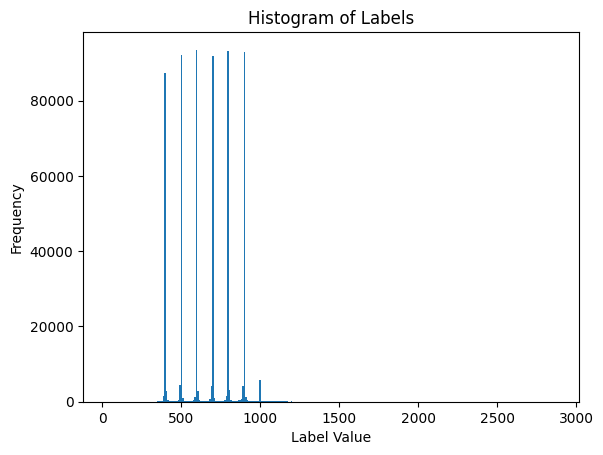

array([ 700.,  700.,  799.,  600.,  351.,  700.,  395.,  400.,  800.,
        500.,  497.,  600.,  800.,  505.,  497.,  715.,  691.,  800.,
        800.,  600.,  897.,  900.,  699.,  599.,  600.,  400.,  416.,
        700.,  796.,  500.,  800.,  906.,  796.,  600.,  497.,  500.,
        700.,  900.,  800.,  799.,  500.,  500.,  700.,  400.,  700.,
        600.,  398.,  700.,  900.,  900.,  599.,  699.,  700.,  505.,
        400.,  900.,  600.,  500.,  393.,  899.,  600.,  400.,  700.,
        700.,  798.,  800.,  500.,  500.,  400.,  500.,  600.,  900.,
        600.,  600.,  797.,  700.,  600.,  401.,  800.,  600.,  400.,
        598.,  900.,  800.,  700.,  799.,  500.,  400.,  900.,  393.,
        500.,  400.,  800.,  900.,  700., 1000.,  400.,  600.,  805.,
        600.], dtype=float32)

In [52]:
plt.hist(np.round(all_labels[:,0]), bins=300)
#plt.hist(all_labels[:,1], bins=100)
plt.xlabel('Label Value')
plt.ylabel('Frequency')
plt.title('Histogram of Labels')
plt.show()
np.round(all_labels)[:100,0]

In [43]:
from collections import Counter

# Count the occurrences of each value in the tensor
counter = Counter(all_labels[:,0])
print(len(counter))

# Get the 10 most common values
most_common = counter.most_common(20)

# Print the 10 most common values and their counts
for value, count in most_common:
    print(f"Value: {value}, Count: {count}")

len(all_labels[:,0])

print(np.sum(np.logical_and(all_labels[:,0] > 300, all_labels[:,0] < 1000))/len(all_labels[:,0]))
print(len(all_labels[:,0]))


5968
Value: 600.0, Count: 74333
Value: 900.0, Count: 74070
Value: 500.0, Count: 73749
Value: 800.0, Count: 73736
Value: 700.0, Count: 73597
Value: 400.0, Count: 68183
Value: 899.0, Count: 7864
Value: 699.0, Count: 7824
Value: 499.0, Count: 7778
Value: 799.0, Count: 7702
Value: 599.0, Count: 7496
Value: 399.0, Count: 7472
Value: 1000.0, Count: 5543
Value: 597.0, Count: 2945
Value: 497.0, Count: 2752
Value: 897.0, Count: 2749
Value: 697.0, Count: 2678
Value: 397.0, Count: 2644
Value: 797.0, Count: 2612
Value: 798.0, Count: 2176
0.985675
600000


# Testing of MAP estimate

In [1]:
import torch
from PhasePicker import PickerNet
from PhasePickerTraining import Picker
import matplotlib.pyplot as plt
from laplace.baselaplace import FullLaplace
from laplace.curvature.backpack import BackPackGGN
import numpy as np
import torch

from laplace import Laplace, marglik_training
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
from PhaseNetPicker import PhaseNetPicker

In [2]:
state_dict = torch.load('/Users/noahliniger/Documents/GitHub/earthquake-monitoring/PhaseNetRegressor.pth')
model = PhaseNetPicker()
model.load_state_dict(state_dict)
csv_files = ['/Users/noahliniger/Downloads/chunk2/chunk2.csv', '/Users/noahliniger/Downloads/chunk3/chunk3.csv', '/Users/noahliniger/Downloads/chunk4/chunk4.csv'] #['data/chunk2.csv', 'data/chunk3.csv', 'data/chunk4.csv']#, 'data/chunk5.csv', 'data/chunk6.csv']
h5_files = ['/Users/noahliniger/Downloads/chunk2/chunk2.hdf5', '/Users/noahliniger/Downloads/chunk3/chunk3.hdf5', '/Users/noahliniger/Downloads/chunk4/chunk4.hdf5'] #['data/chunk2.hdf5', 'data/chunk3.hdf5', 'data/chunk4.hdf5']#, 'data/chunk5.hdf5', 'data/chunk6.hdf5']
picker = Picker(csv_files=csv_files, h5_files=h5_files, model=model)
print("Creating the data loaders...")
picker.createDataLoaders(frac_train=0.7, frac_test=0.15, batch_size=32, return_snr=False, input_length=5864)
print("Created the data loaders...")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)
model.to(device)

Device: mps
Creating the data loaders...
Created the data loaders...
Device: mps


PhaseNetPicker(
  (inc): Conv1d(1, 8, kernel_size=(7,), stride=(1,), padding=same)
  (in_bn): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (down_branch): ModuleList(
    (0): ModuleList(
      (0): Conv1d(8, 8, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(8, 8, kernel_size=(7,), stride=(4,), padding=(3,), bias=False)
      (3): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ModuleList(
      (0): Conv1d(8, 16, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(16, 16, kernel_size=(7,), stride=(4,), bias=False)
      (3): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ModuleList(
      (0): Conv1d(16, 32, kernel_size=(7,), stri

In [3]:
distances = []
for i, (waves, labels) in enumerate(picker.test_loader):
    waves, labels = waves.to(device), labels.to(device)
    out = model(waves)
    break
waves.shape

torch.Size([32, 1, 5864])

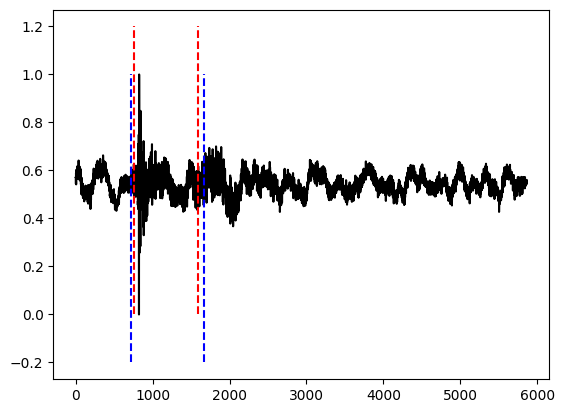

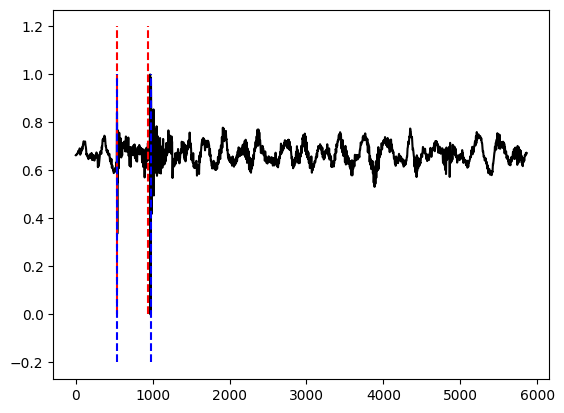

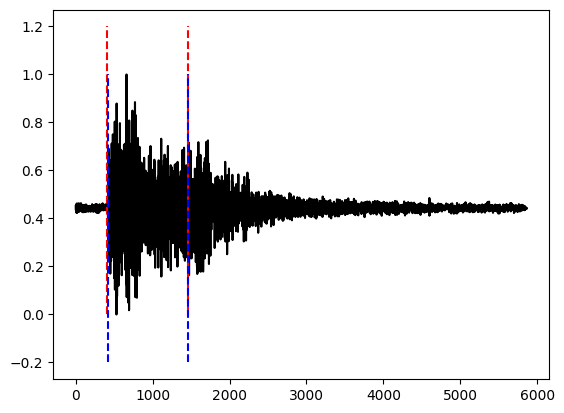

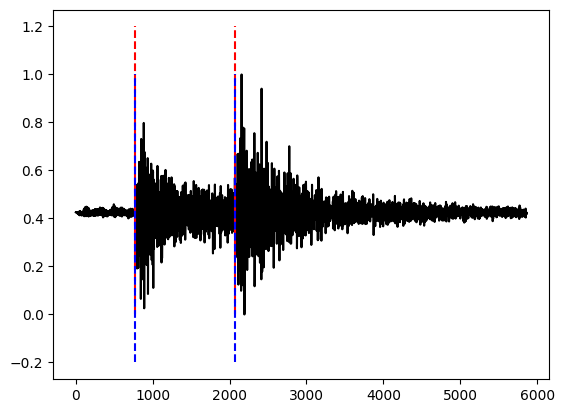

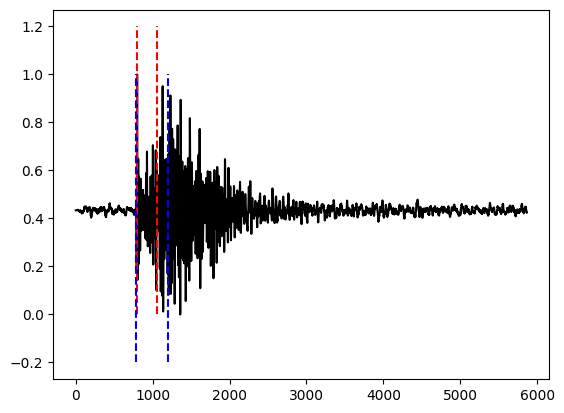

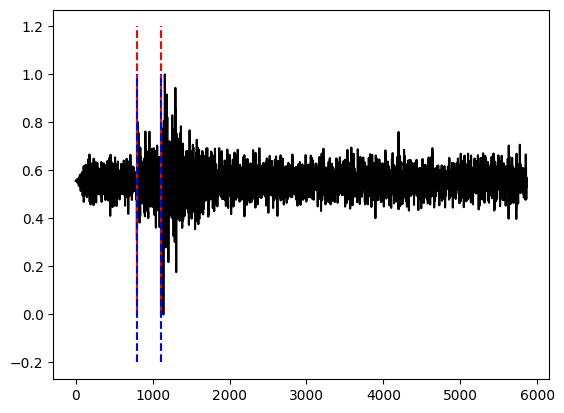

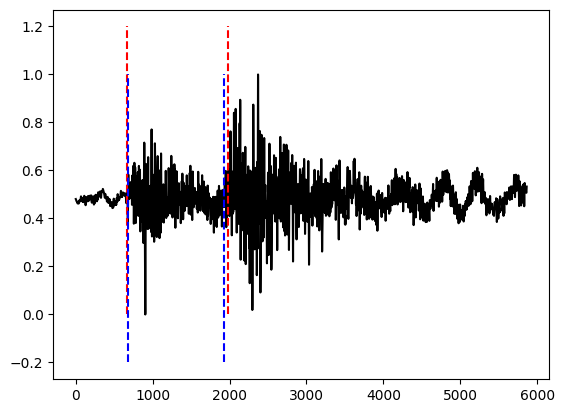

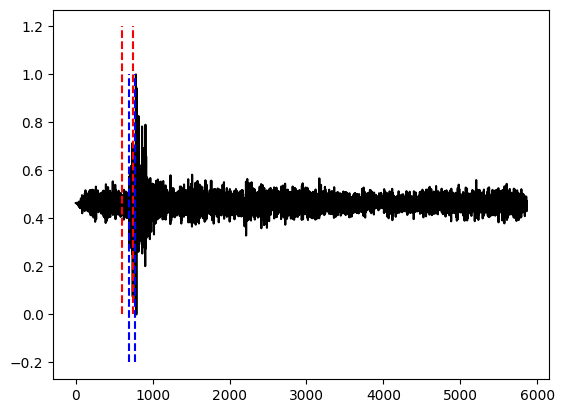

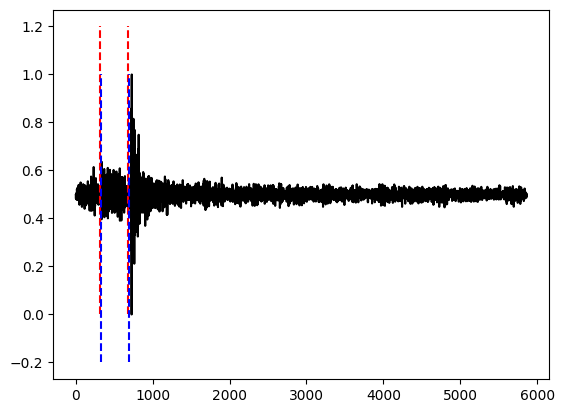

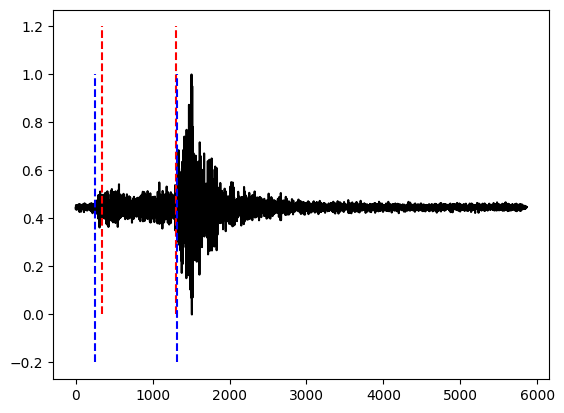

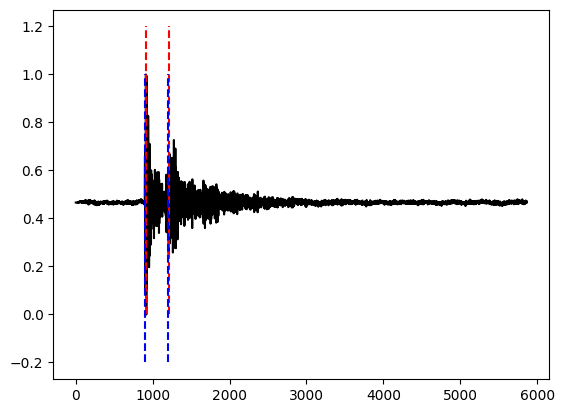

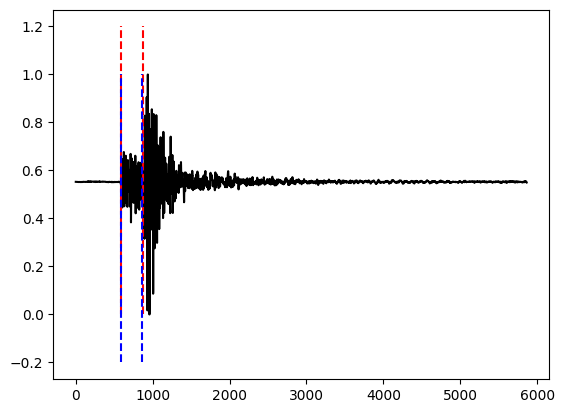

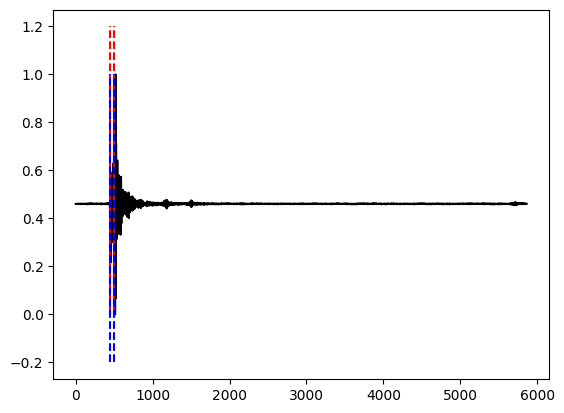

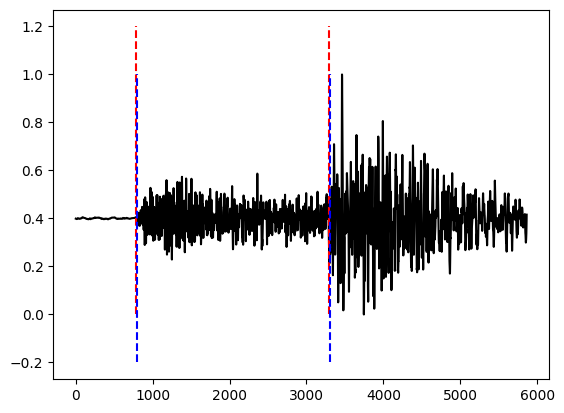

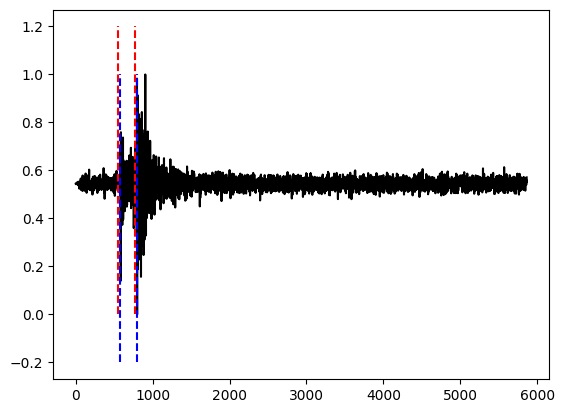

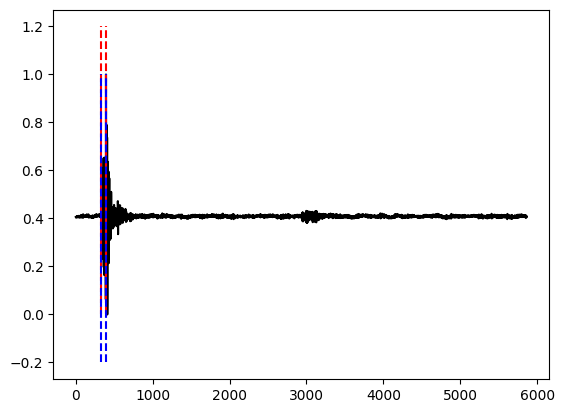

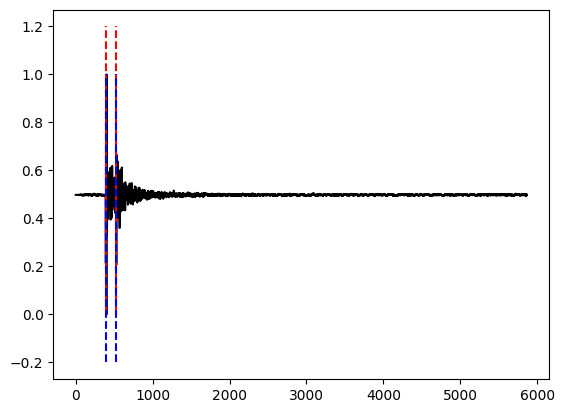

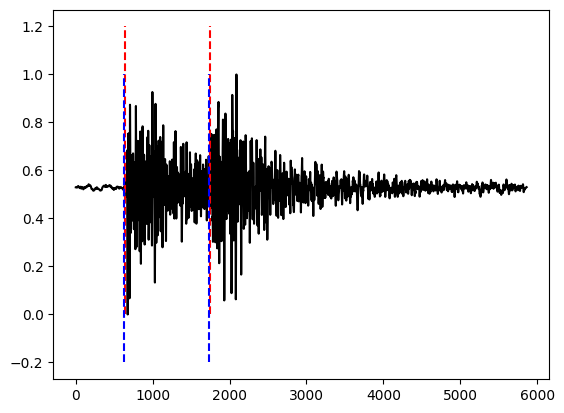

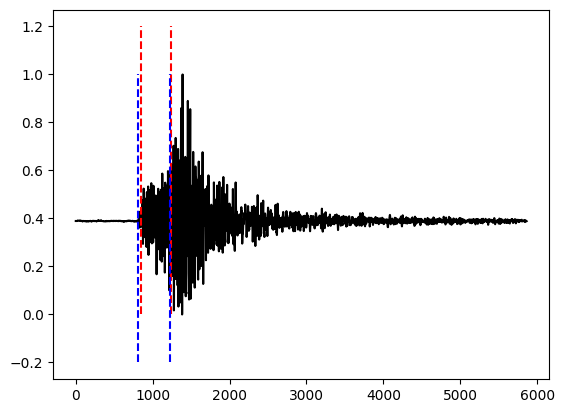

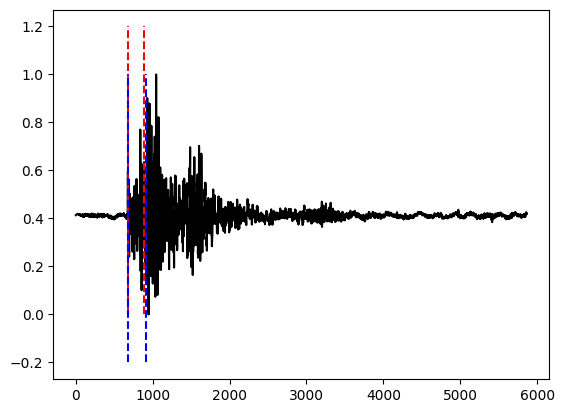

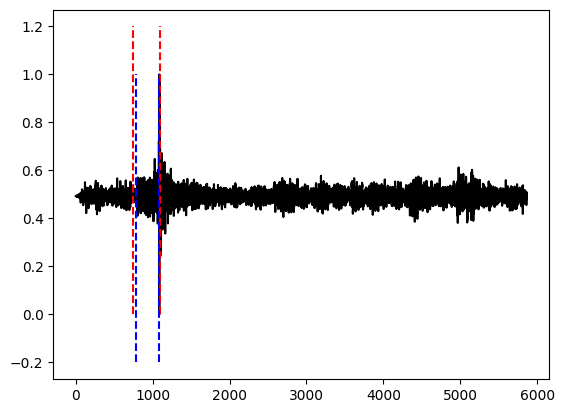

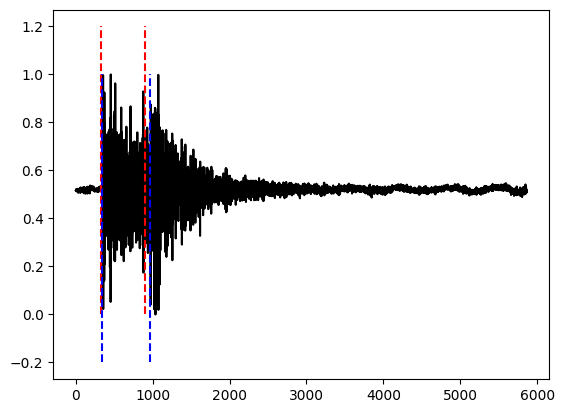

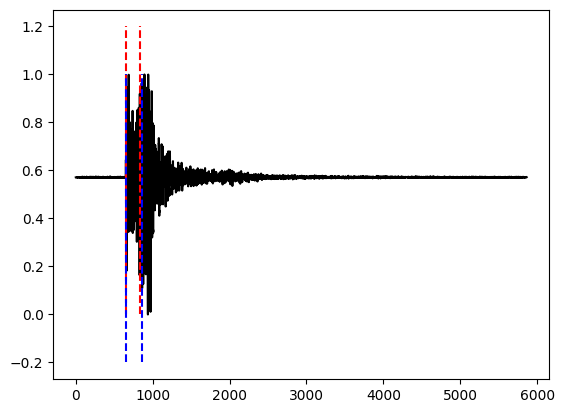

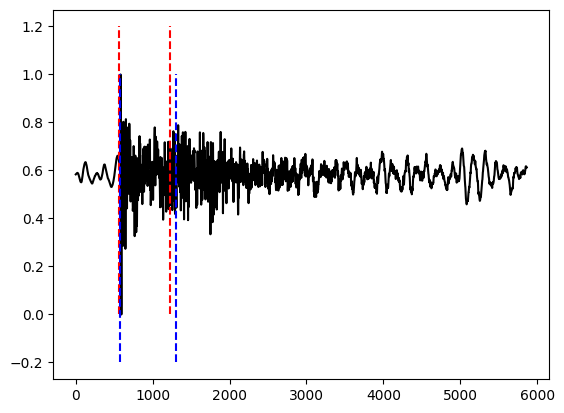

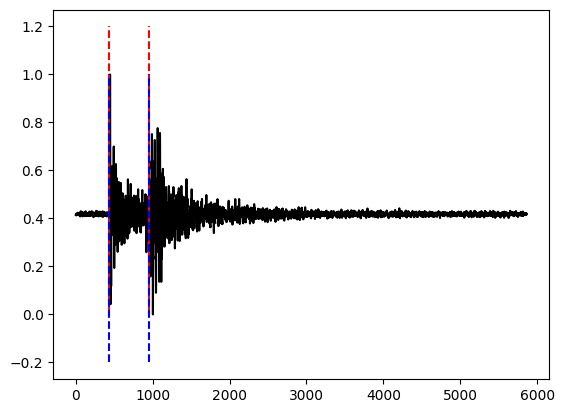

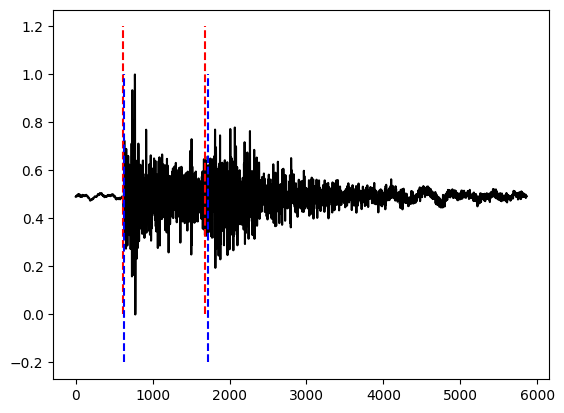

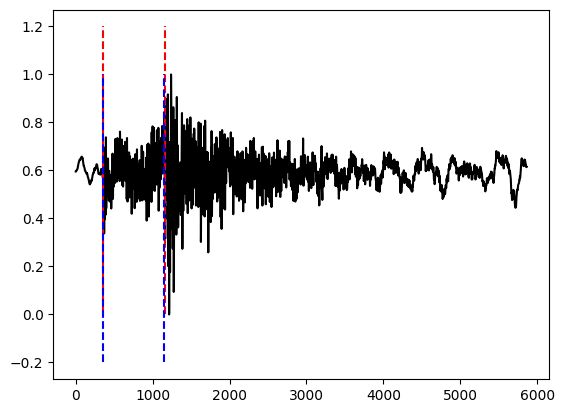

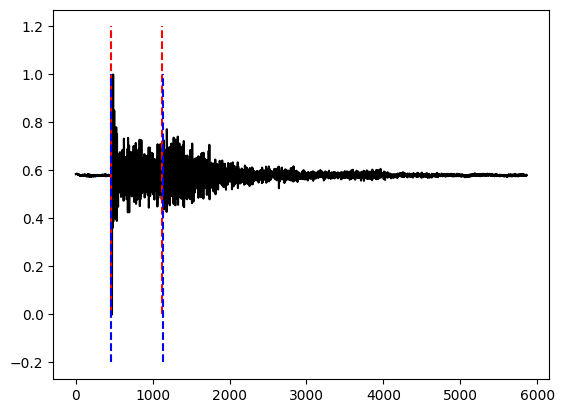

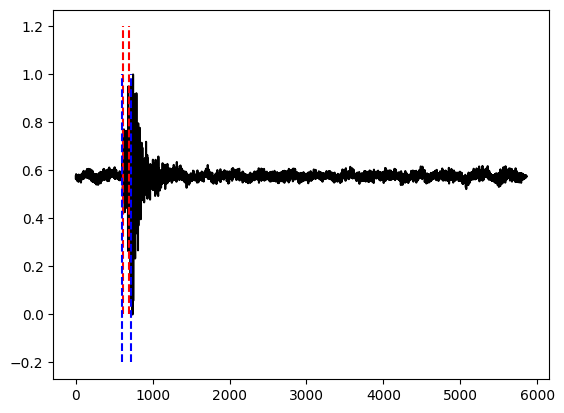

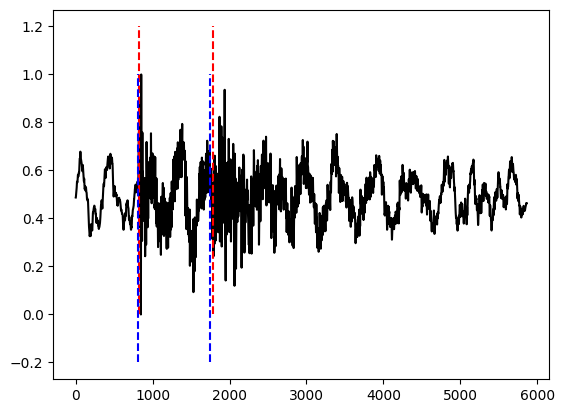

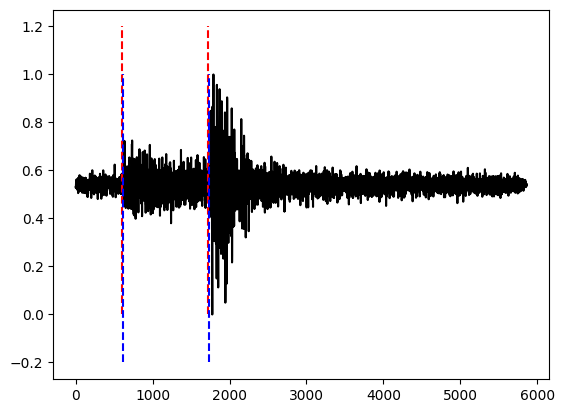

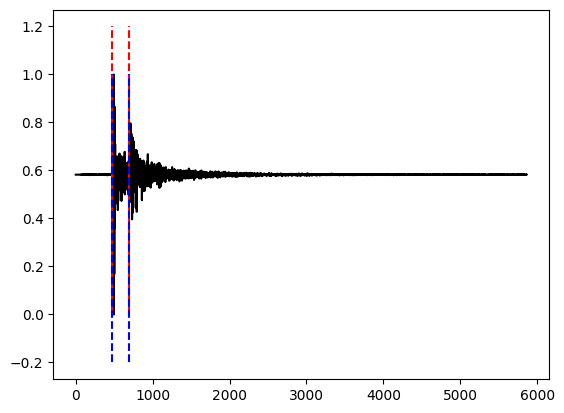

In [5]:
x = np.linspace(start=0,stop=5864, num=5864)
for i in range(32):
    plt.plot(x, waves[i,:,:].squeeze().detach().cpu().numpy(),"k")
    plt.vlines(out[i,0].detach().cpu().numpy(), ymax=1.2, ymin=0, colors="r", label="MAP", linestyles="--")
    plt.vlines(labels[i,0].detach().cpu().numpy(), ymax=1, ymin=-0.2, colors="b", label="true label", linestyles="--")
    plt.vlines(out[i,1].detach().cpu().numpy(), ymax=1.2, ymin=0, colors="r", label="MAP", linestyles="--")
    plt.vlines(labels[i,1].detach().cpu().numpy(), ymax=1, ymin=-0.2, colors="b", label="true label", linestyles="--")
    plt.show()

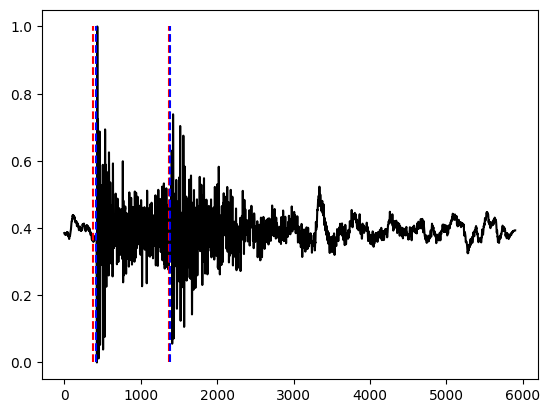

In [73]:
x = np.linspace(start=0,stop=5900, num=5900)
for i in range(3,4):
    plt.plot(x, waves[i,:,:].squeeze().detach().cpu().numpy(),"k")
    plt.vlines(out[i,0].detach().cpu().numpy(), ymax=1, ymin=0, colors="r", label="MAP", linestyles="--")
    plt.vlines(labels[i,0].detach().cpu().numpy(), ymax=1, ymin=0, colors="b", label="true label", linestyles="--")
    plt.vlines(out[i,1].detach().cpu().numpy(), ymax=1, ymin=0, colors="r", label="MAP", linestyles="--")
    plt.vlines(labels[i,1].detach().cpu().numpy(), ymax=1, ymin=0, colors="b", label="true label", linestyles="--")
    plt.show()

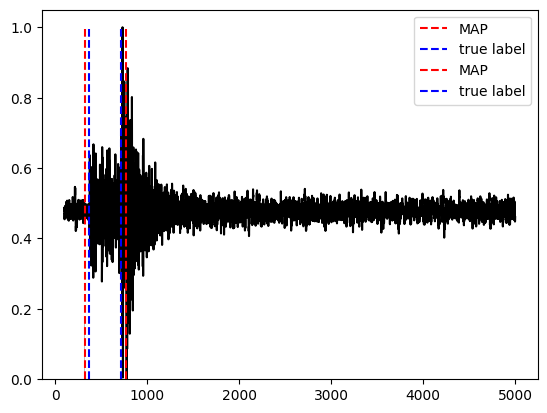

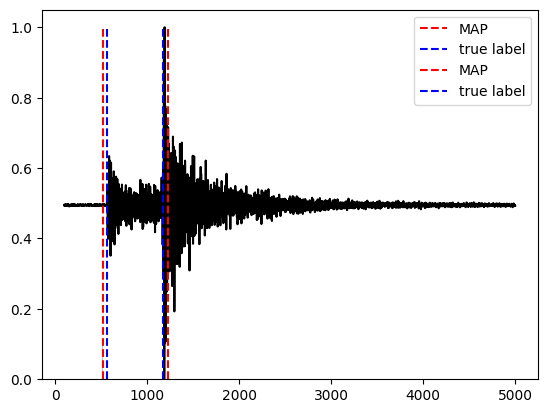

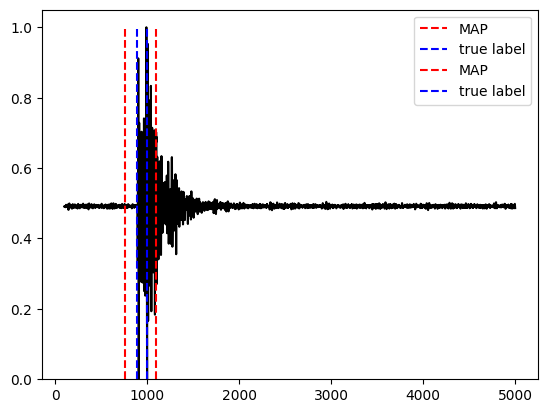

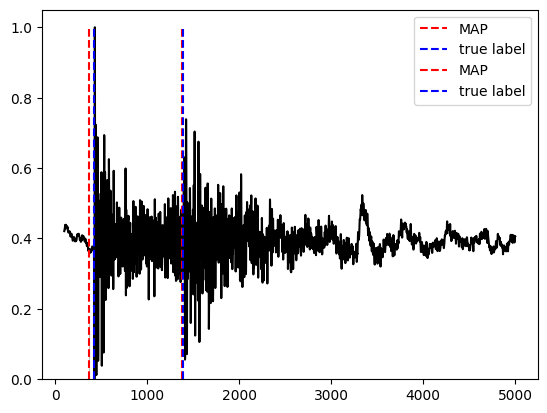

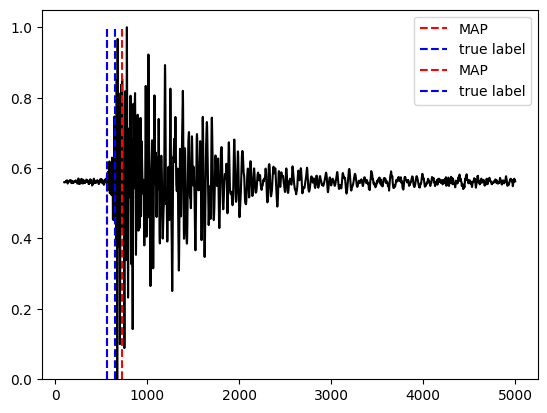

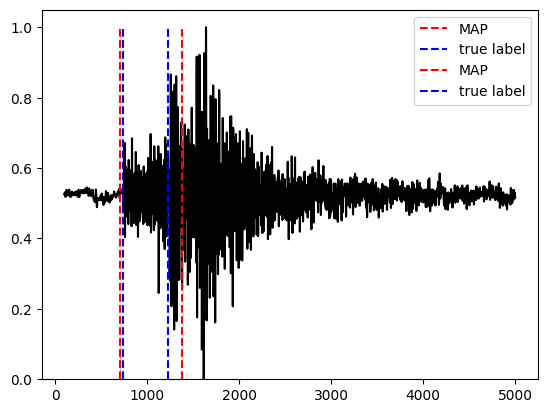

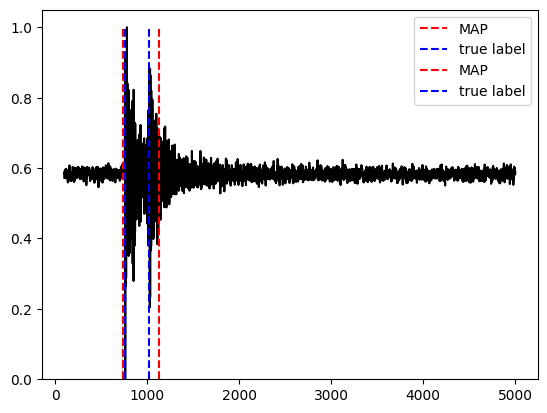

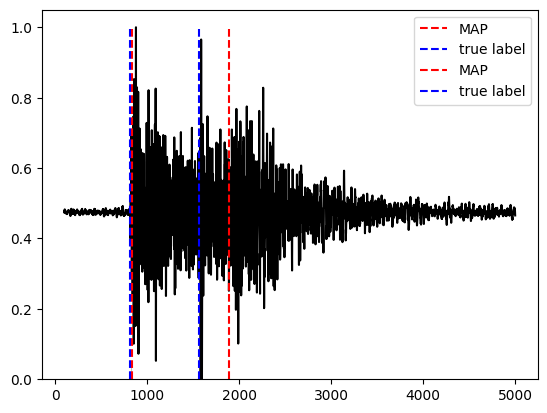

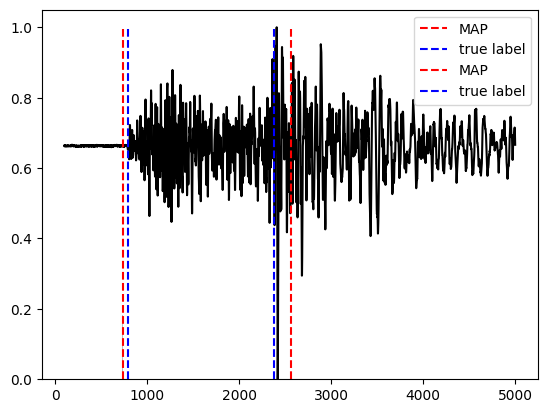

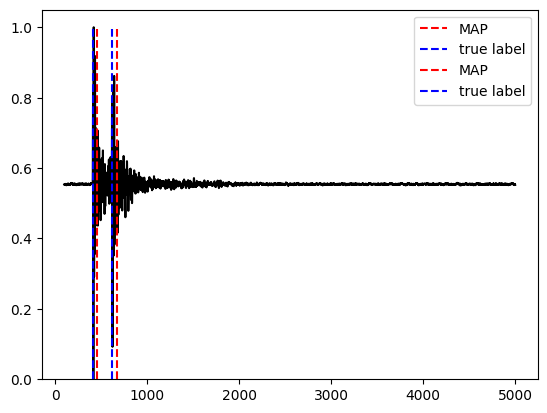

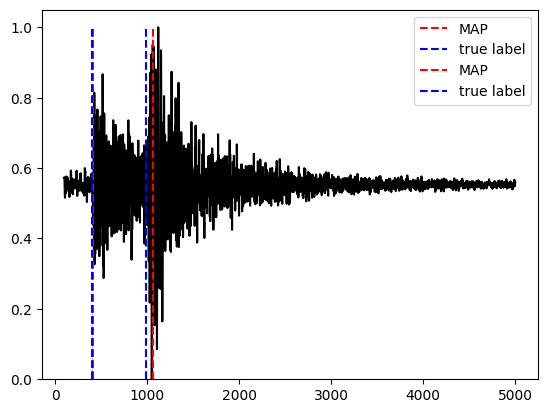

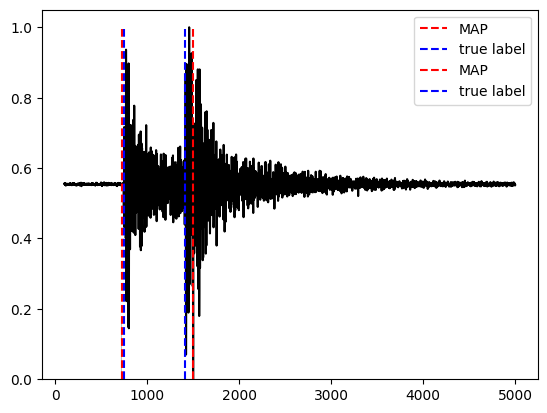

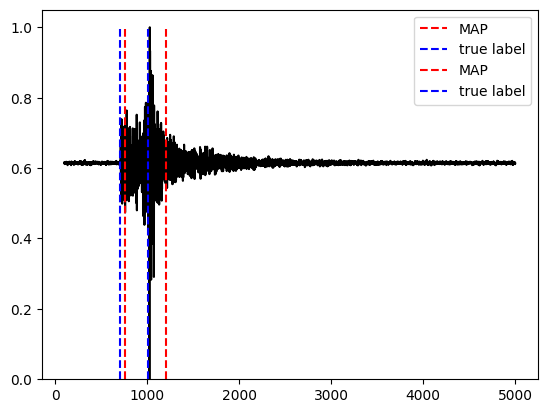

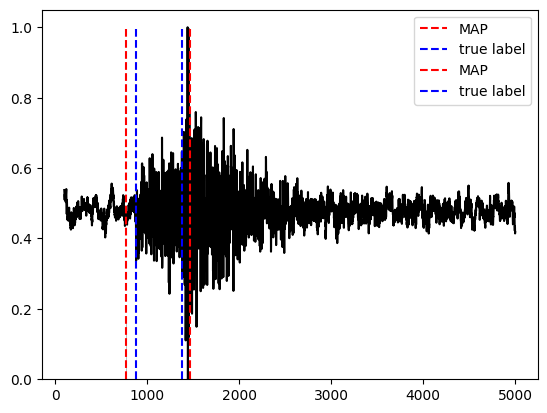

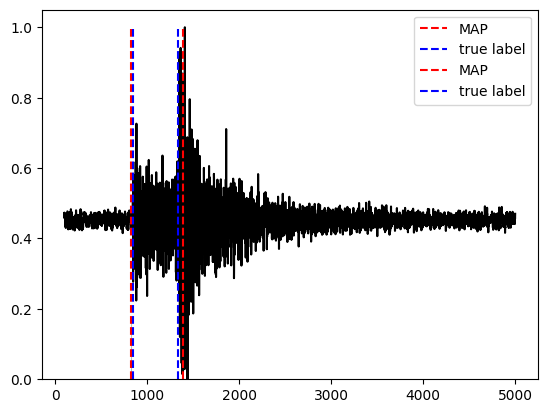

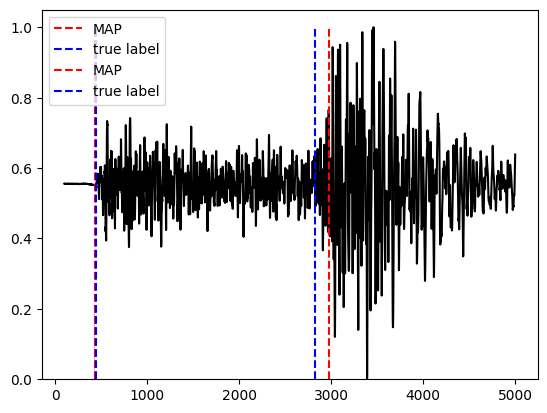

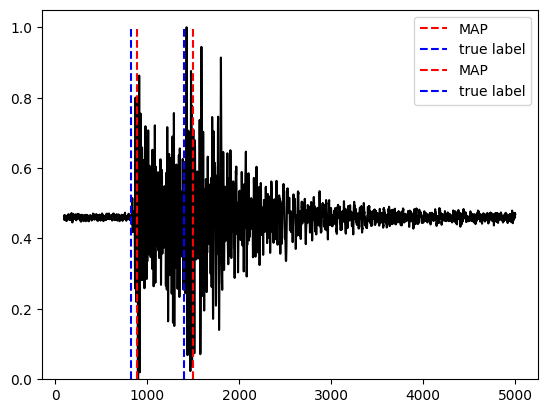

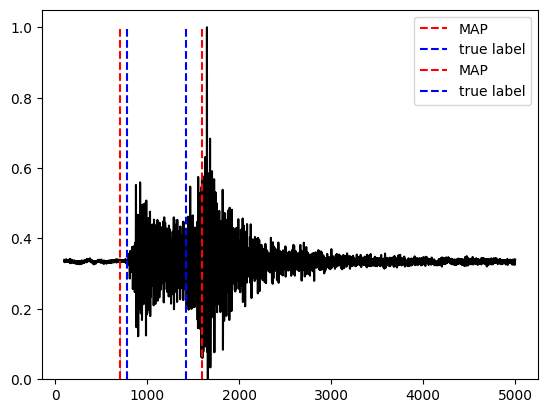

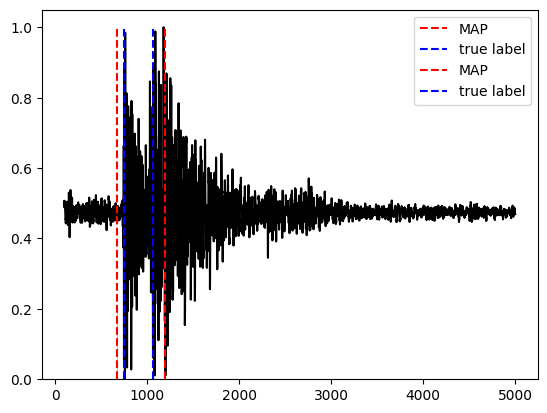

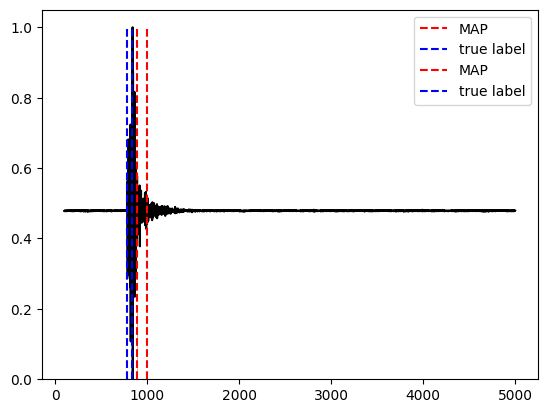

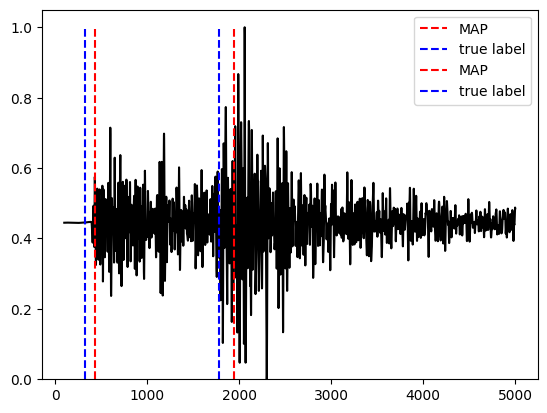

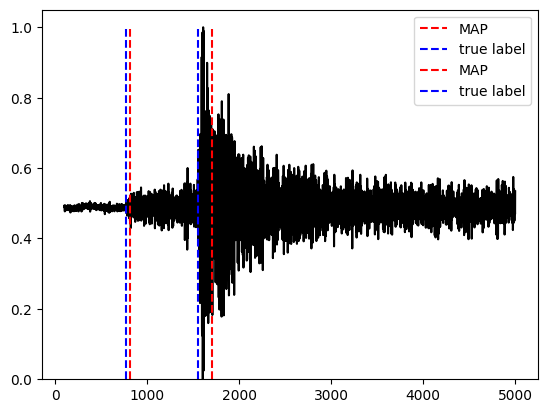

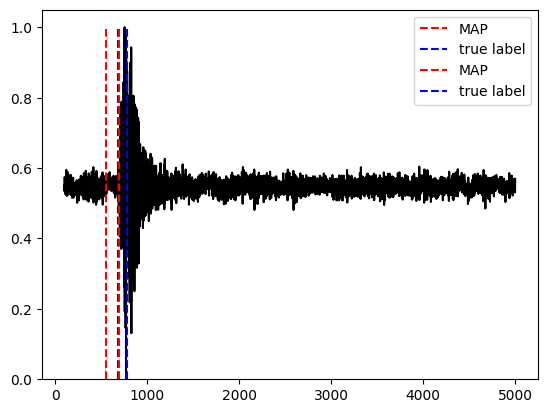

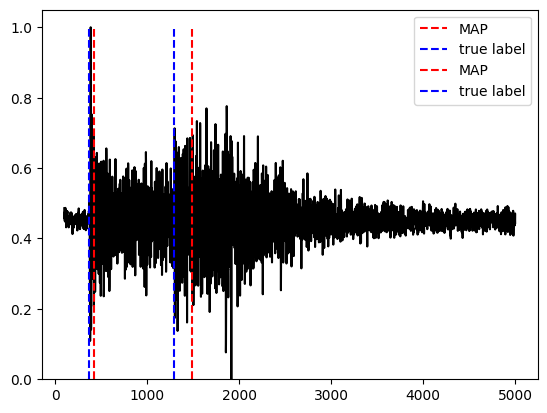

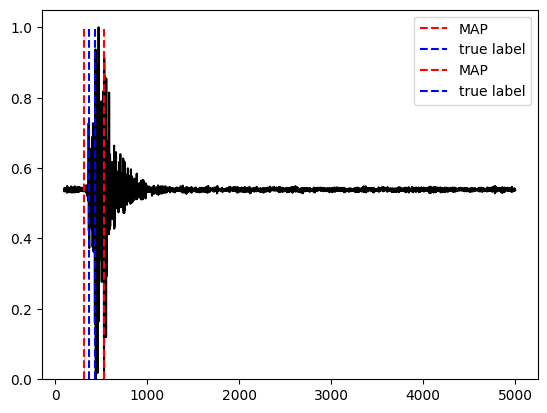

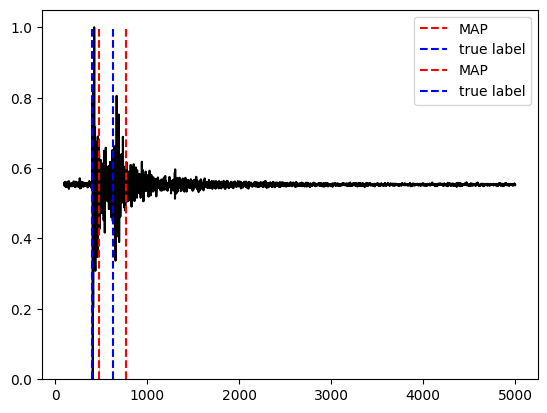

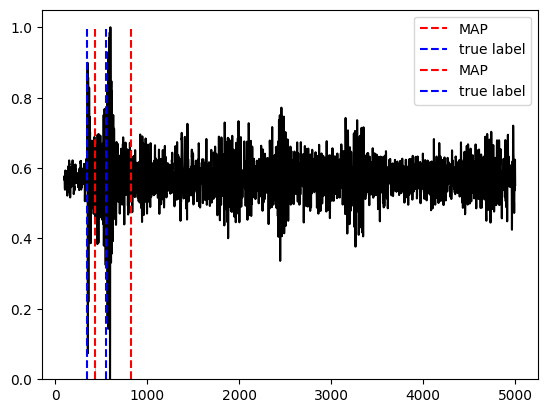

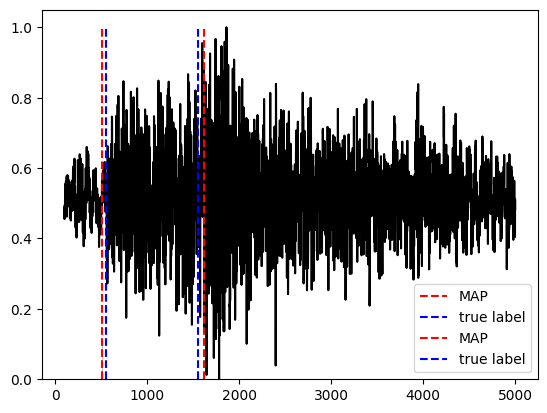

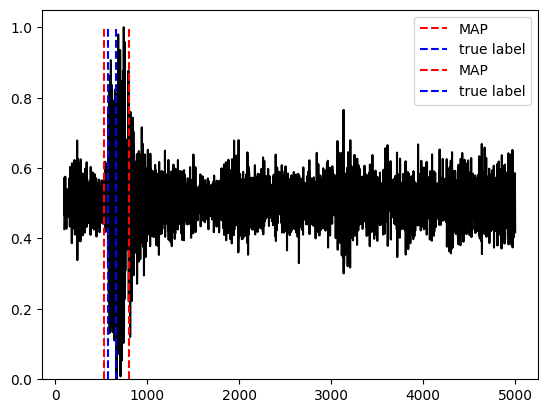

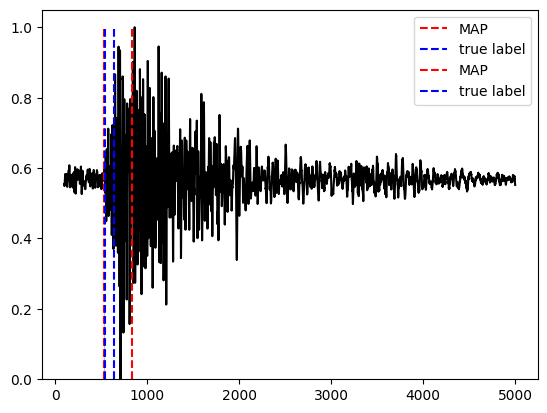

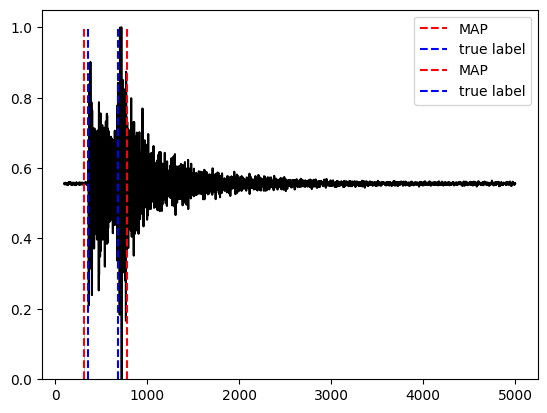

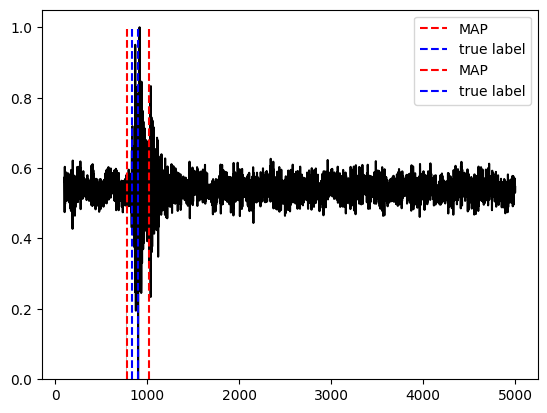

In [86]:
x = np.linspace(start=0,stop=5900, num=5900)
min = 100
max =5000
for i in range(32):
    plt.plot(x[min:max], waves[i,0,min:max].detach().cpu().numpy(),"k")
    plt.vlines(out[i,0].detach().cpu().numpy(), ymax=1, ymin=0, colors="r", label="MAP", linestyles="--")
    plt.vlines(labels[i,0].detach().cpu().numpy(), ymax=1, ymin=0, colors="b", label="true label", linestyles="--")
    plt.vlines(out[i,1].detach().cpu().numpy(), ymax=1, ymin=0, colors="r", label="MAP", linestyles="--")
    plt.vlines(labels[i,1].detach().cpu().numpy(), ymax=1, ymin=0, colors="b", label="true label", linestyles="--")
    plt.legend()
    # Generating Gaussian data points centered at out[i,0] with a std deviation of 0.007
    gaussian_data = np.random.normal(out[i,0].detach().cpu().numpy(), 2, 10000)
    # Plotting the histogram of the Gaussian data
    plt.hist(gaussian_data, bins=30, alpha=0.5, color='gray', density=True)
    plt.show()

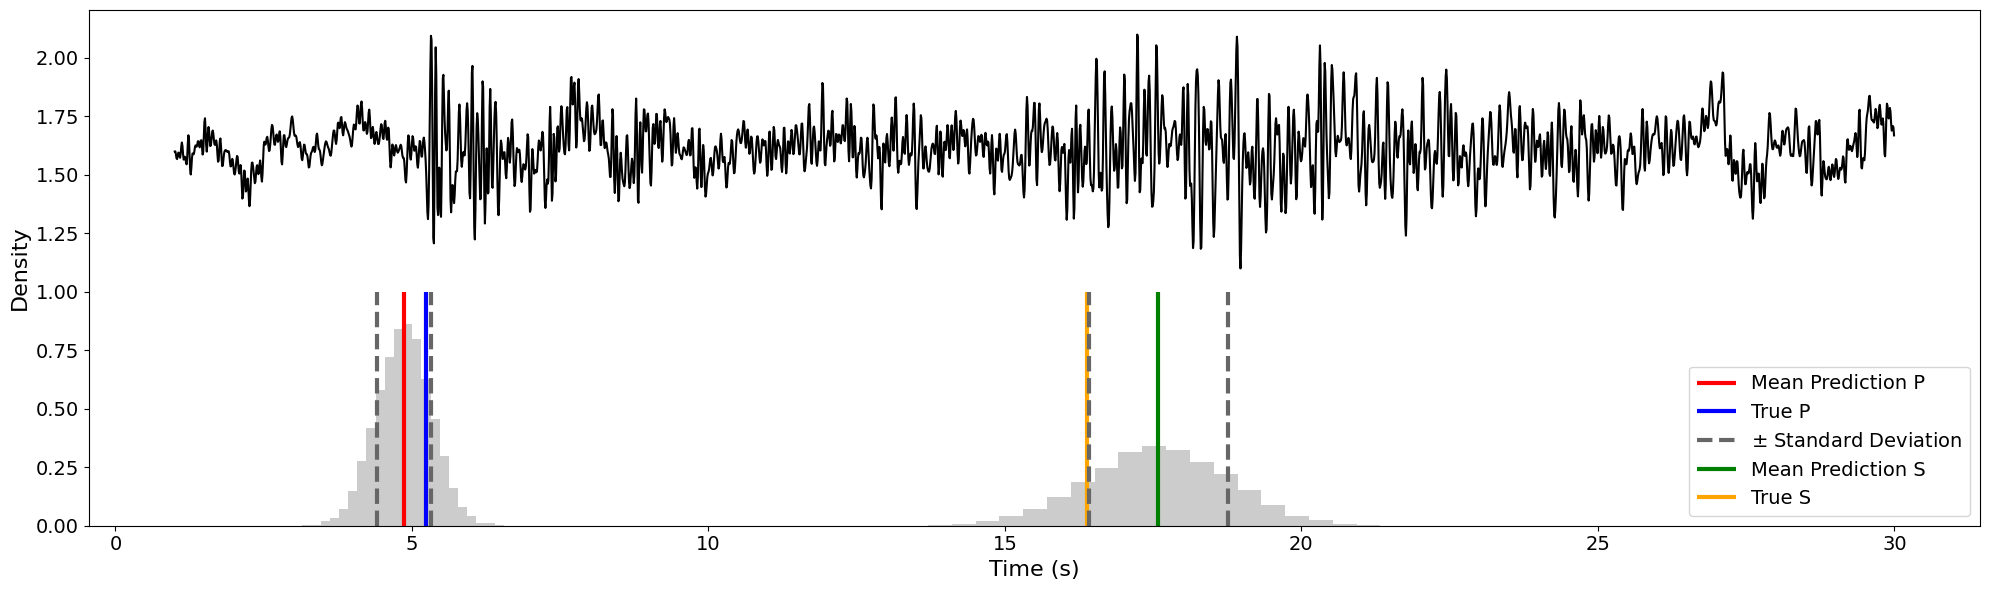

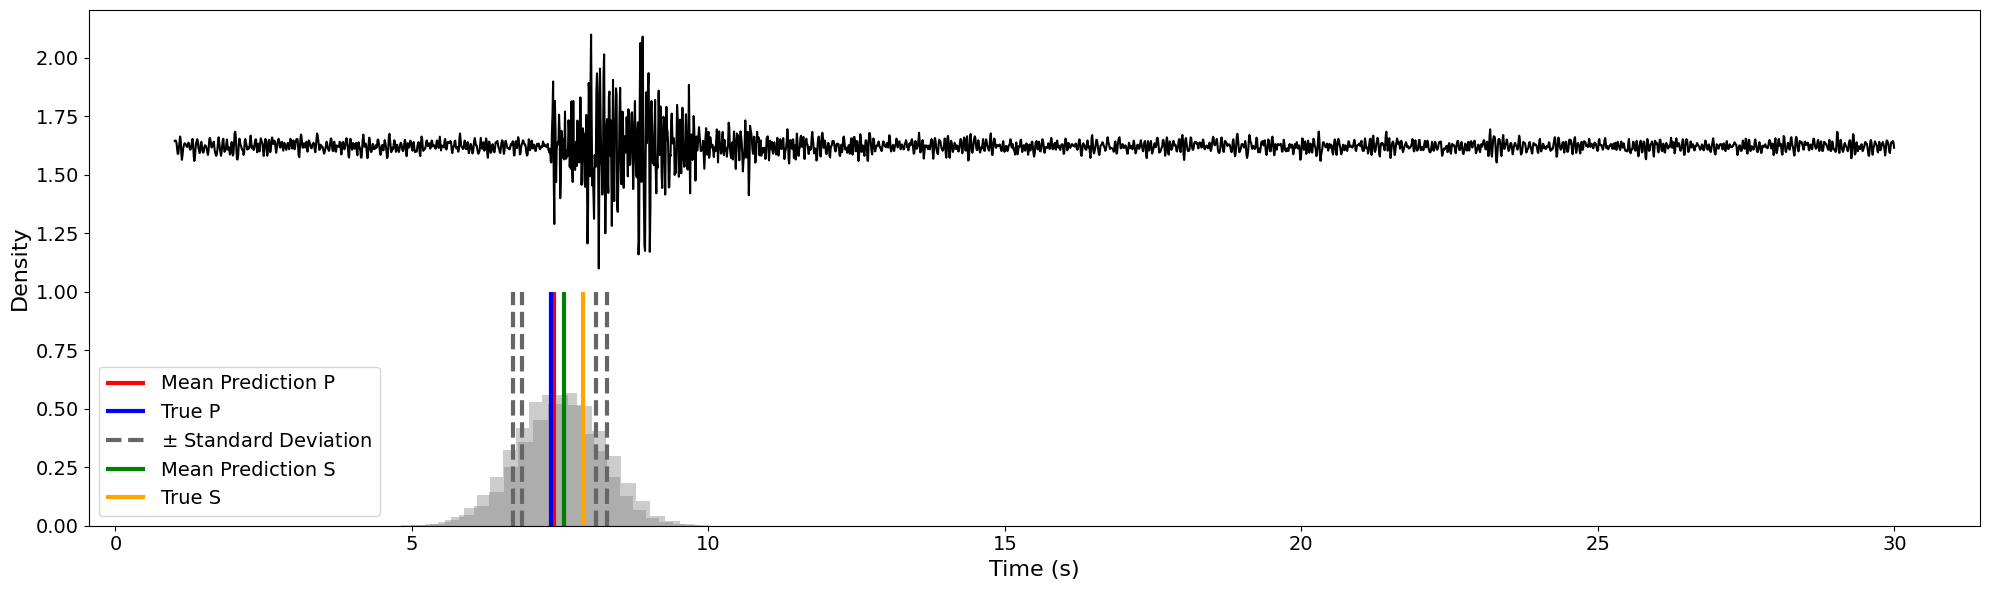

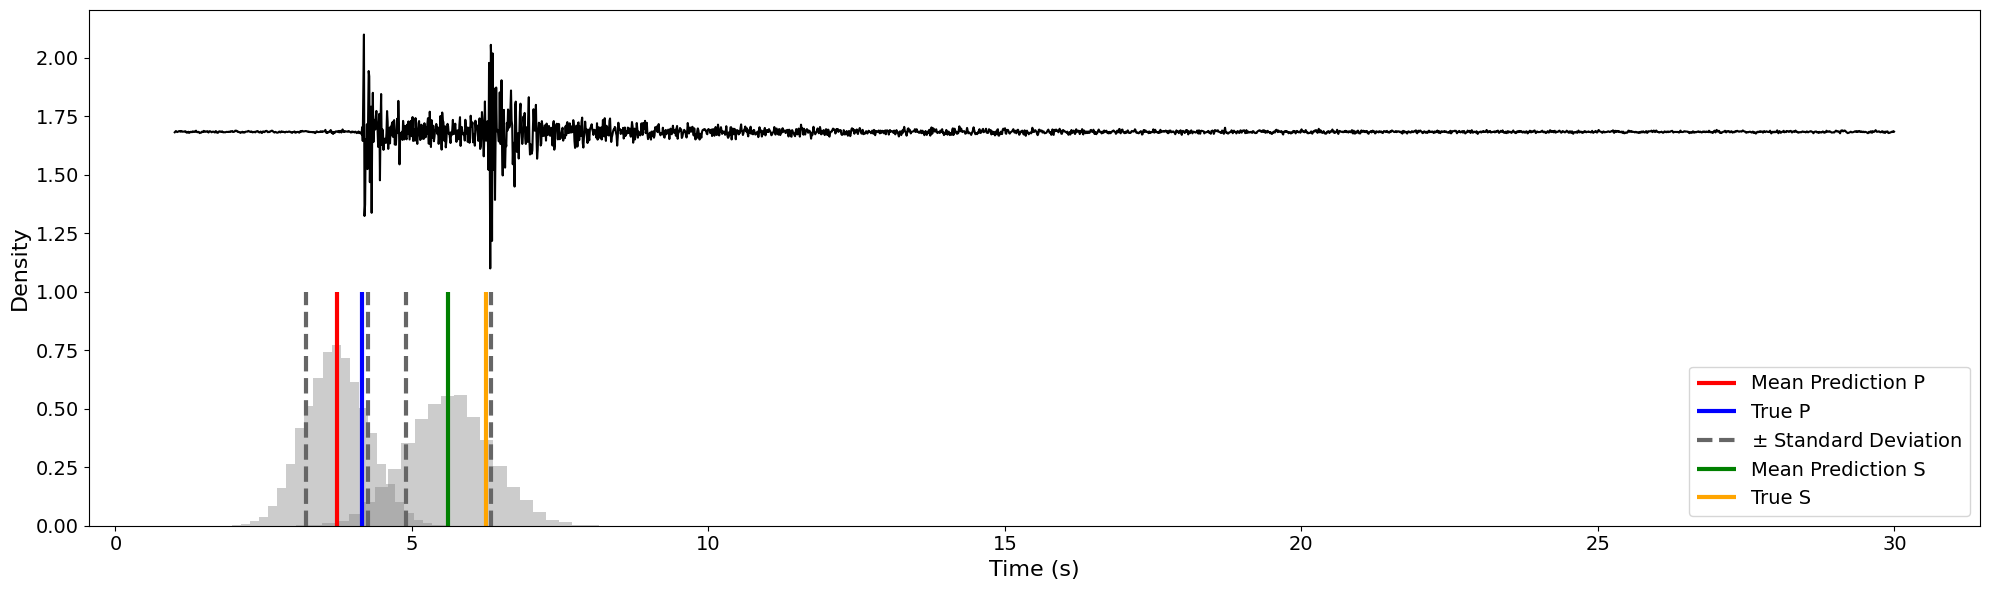

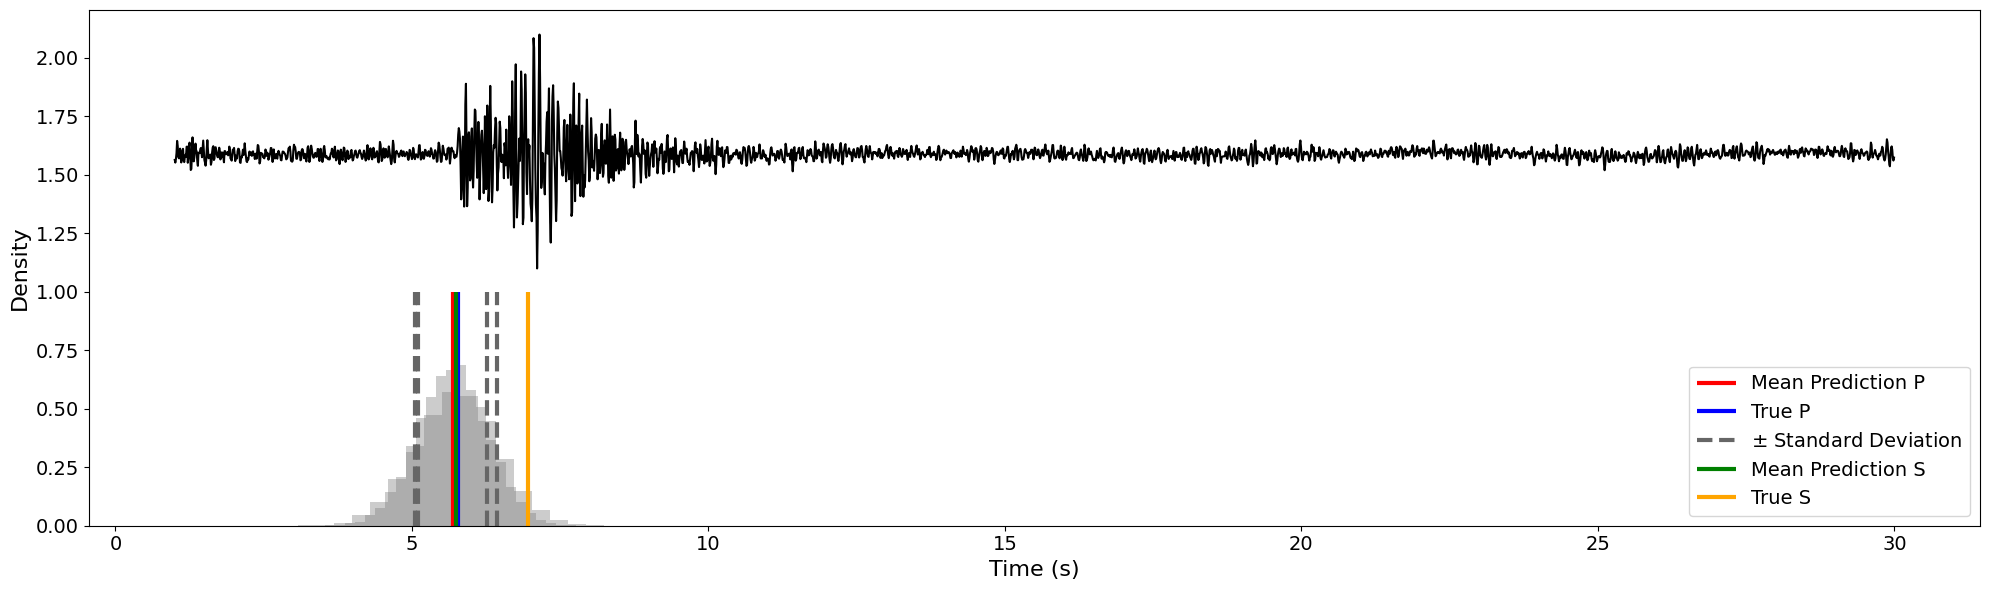

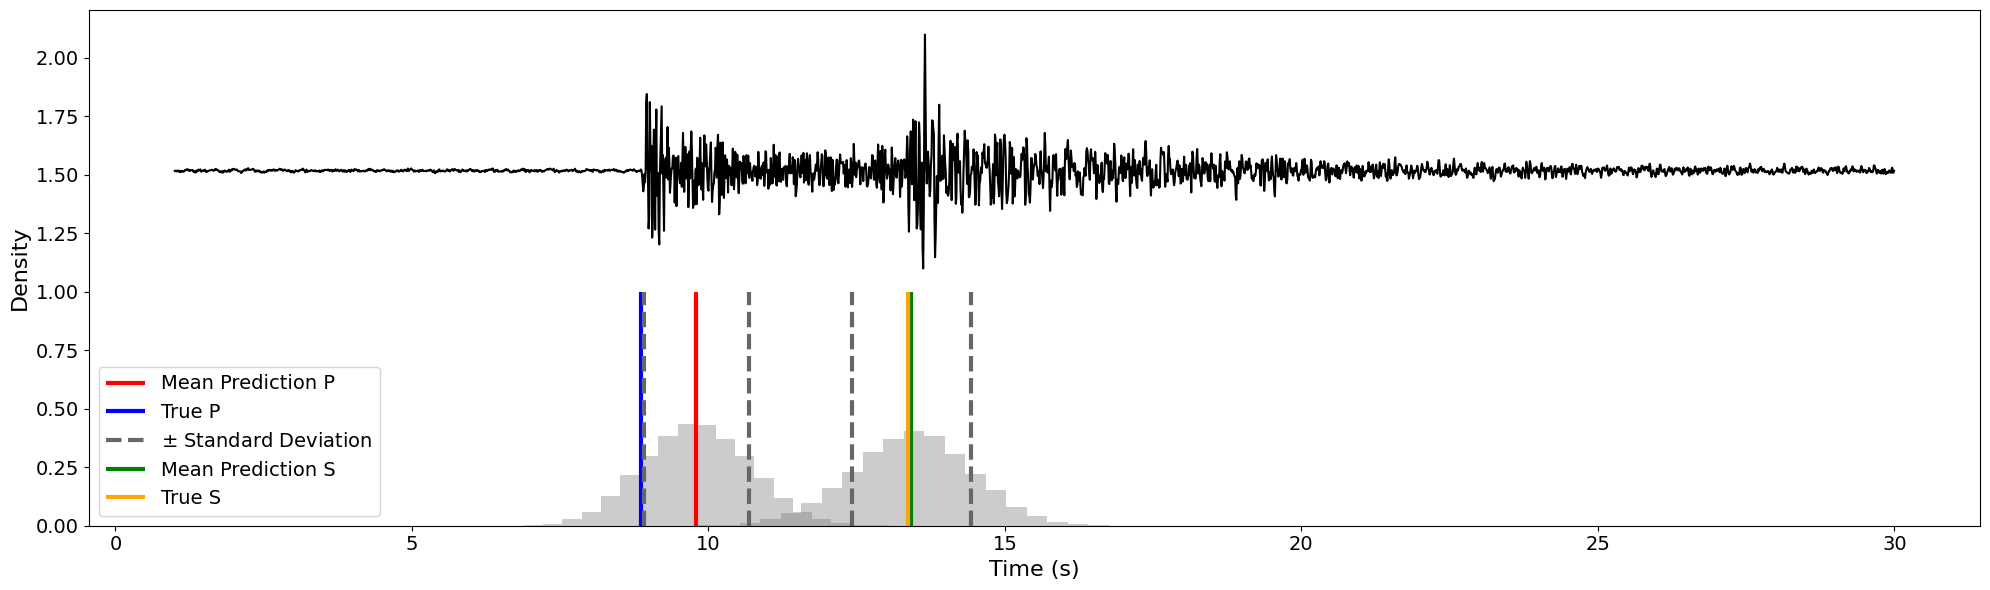

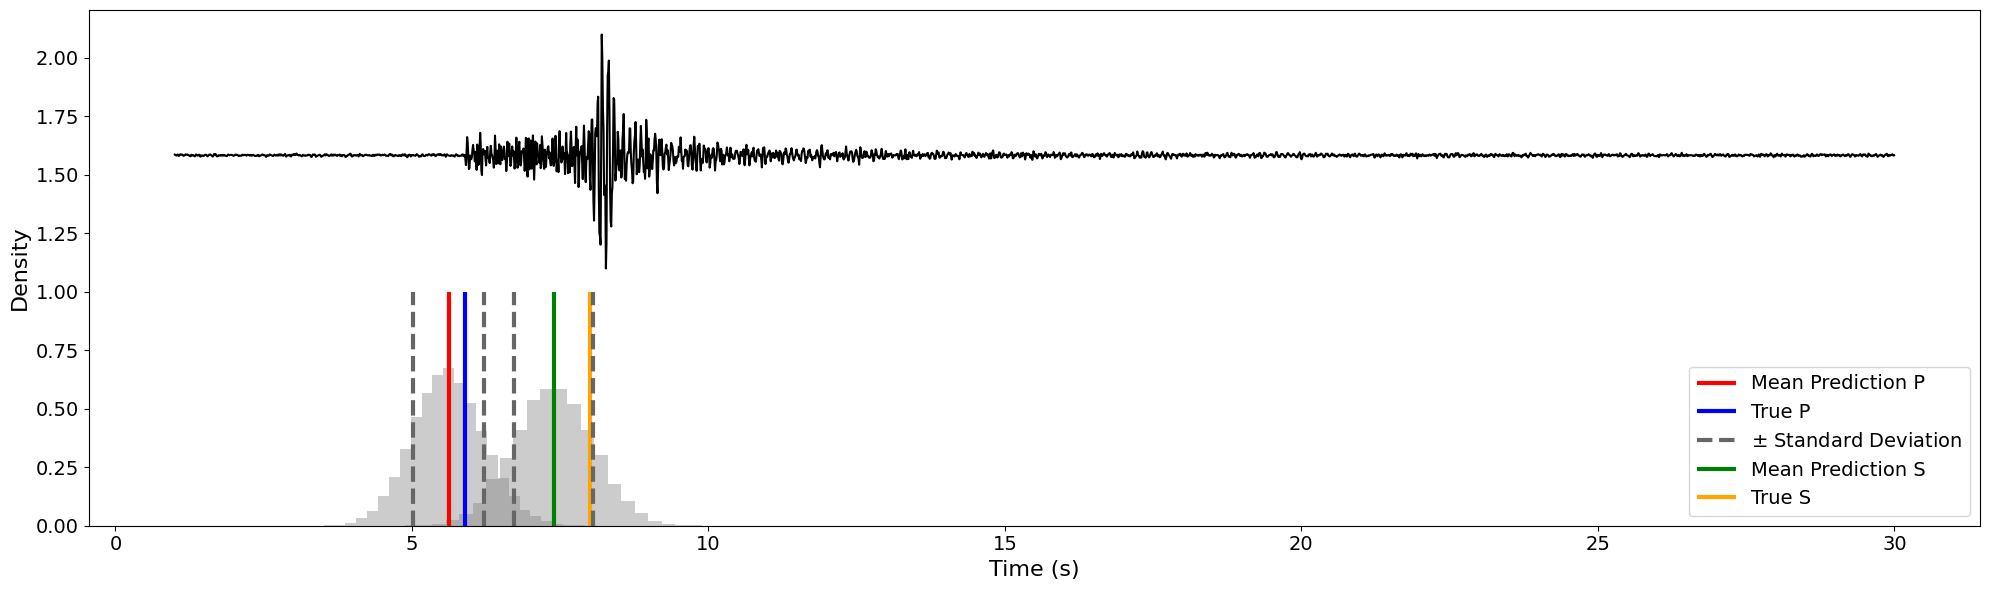

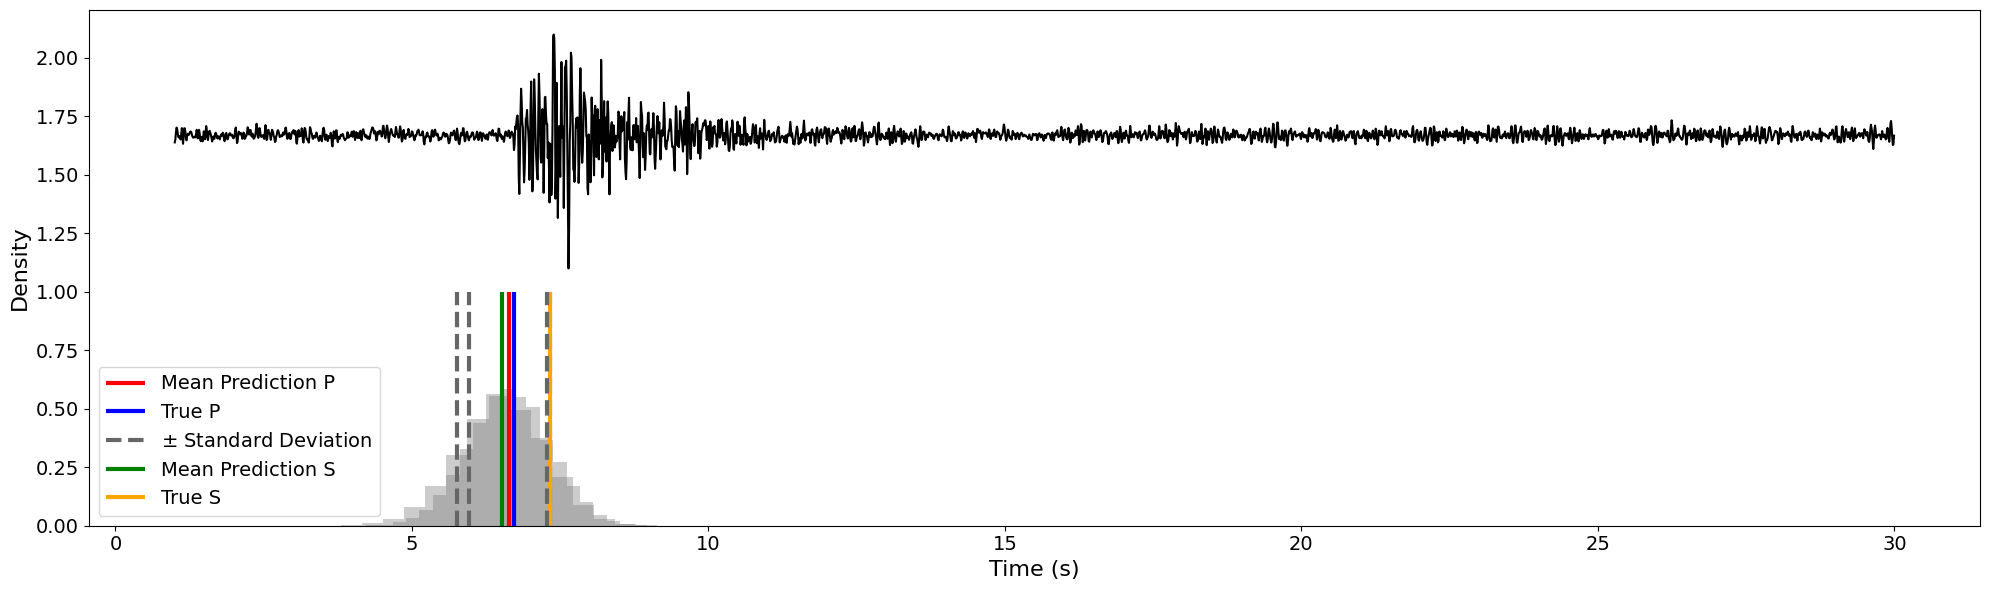

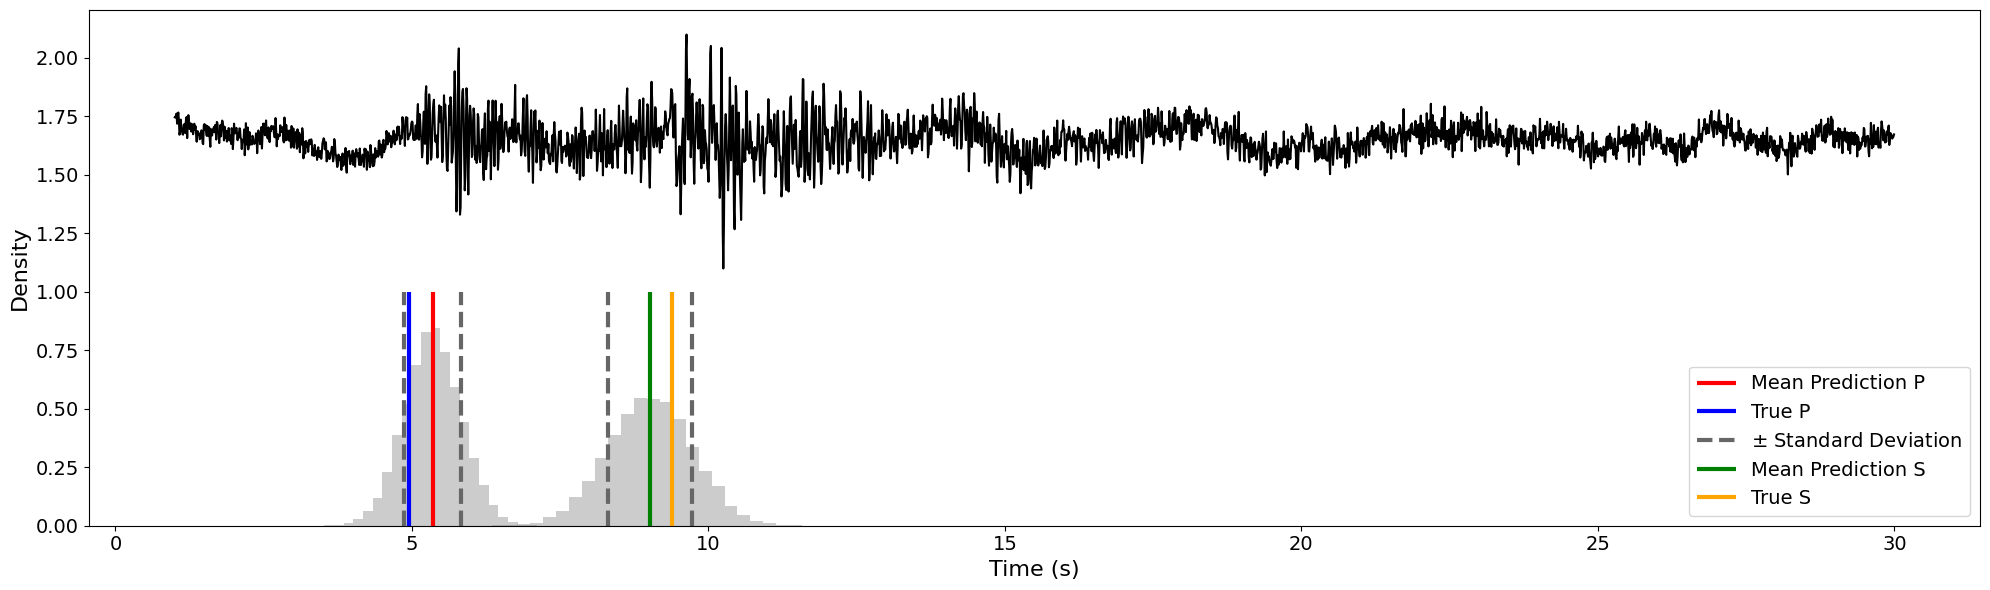

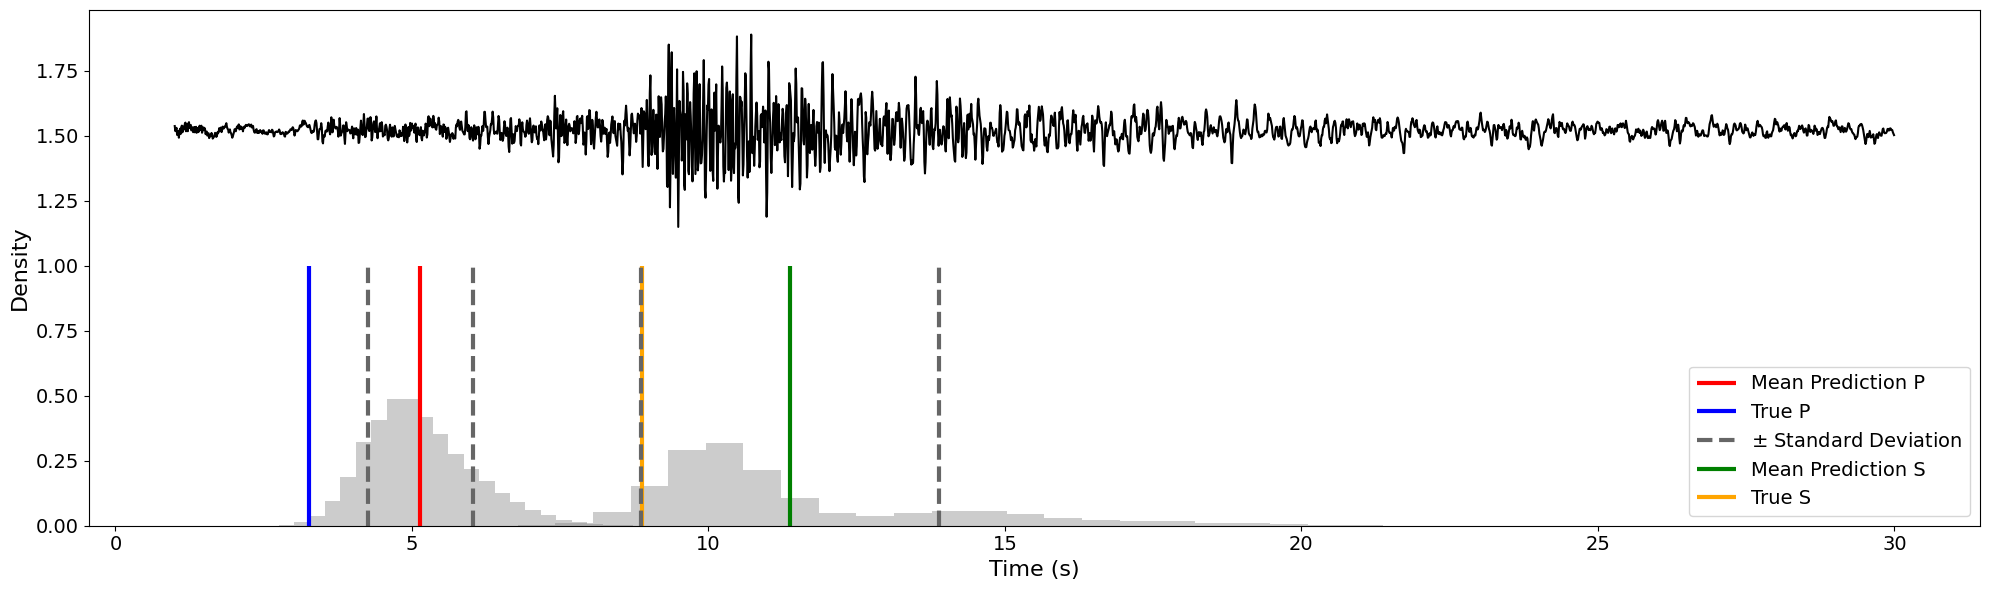

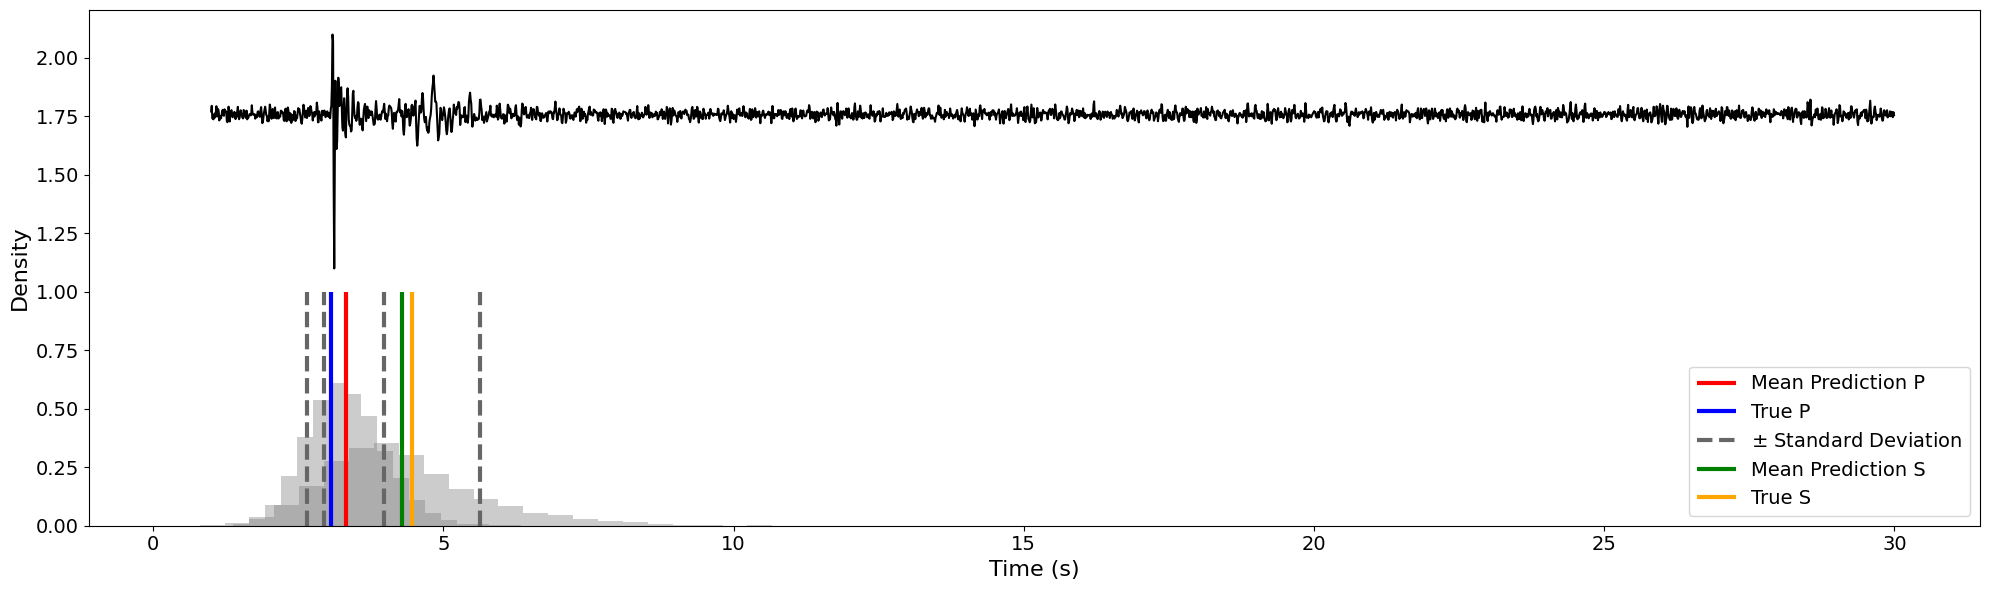

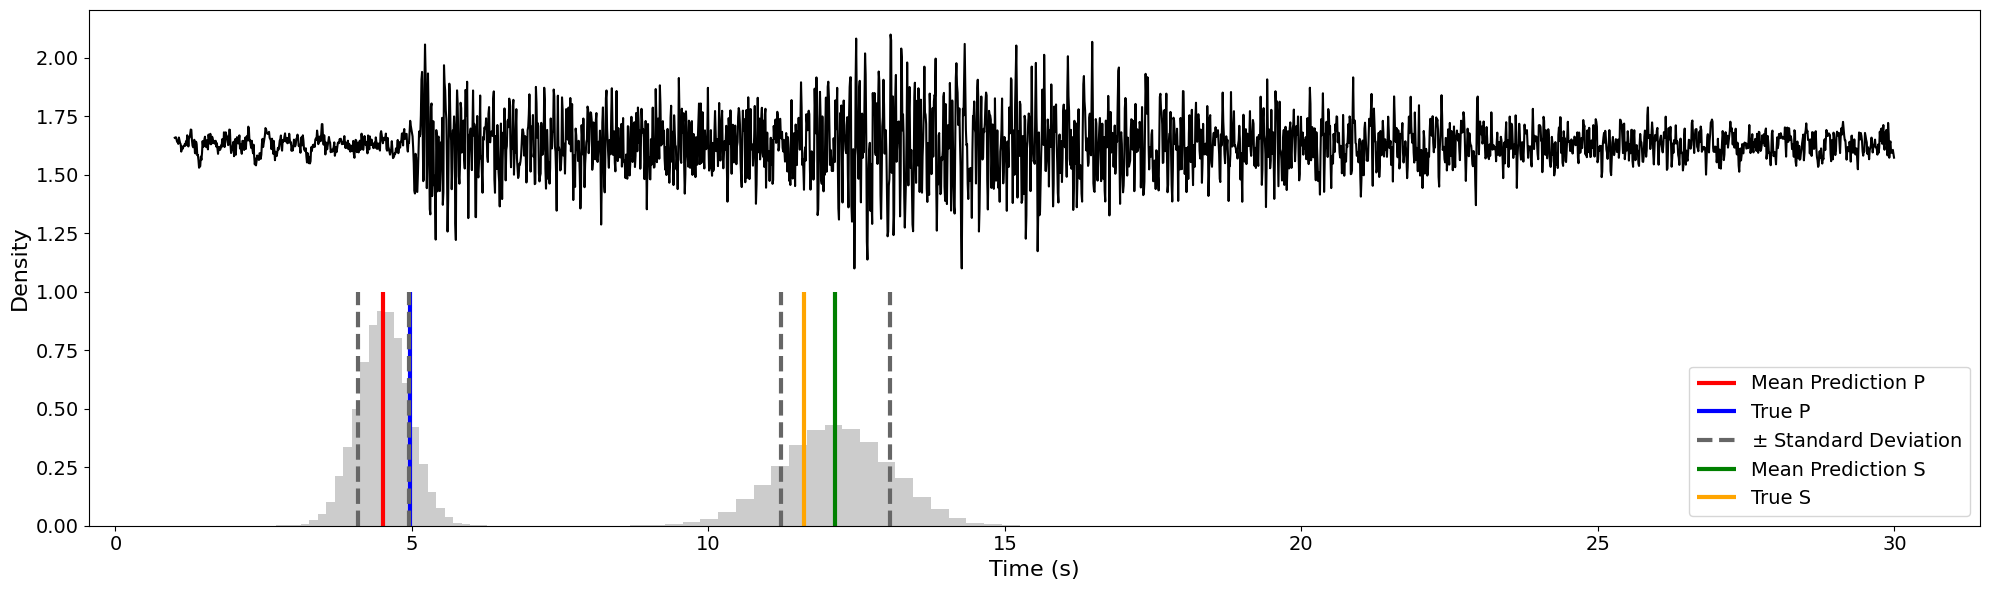

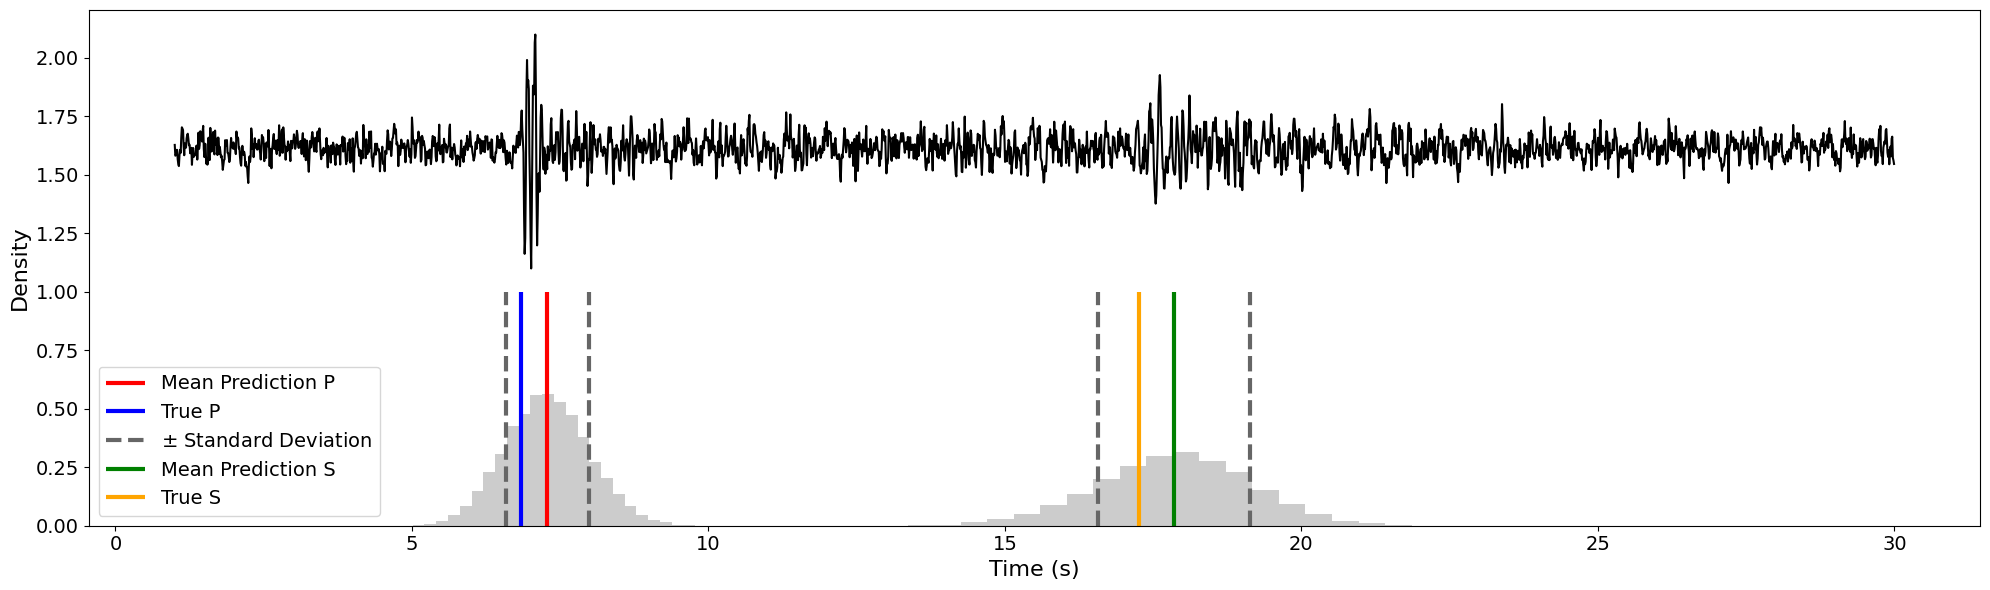

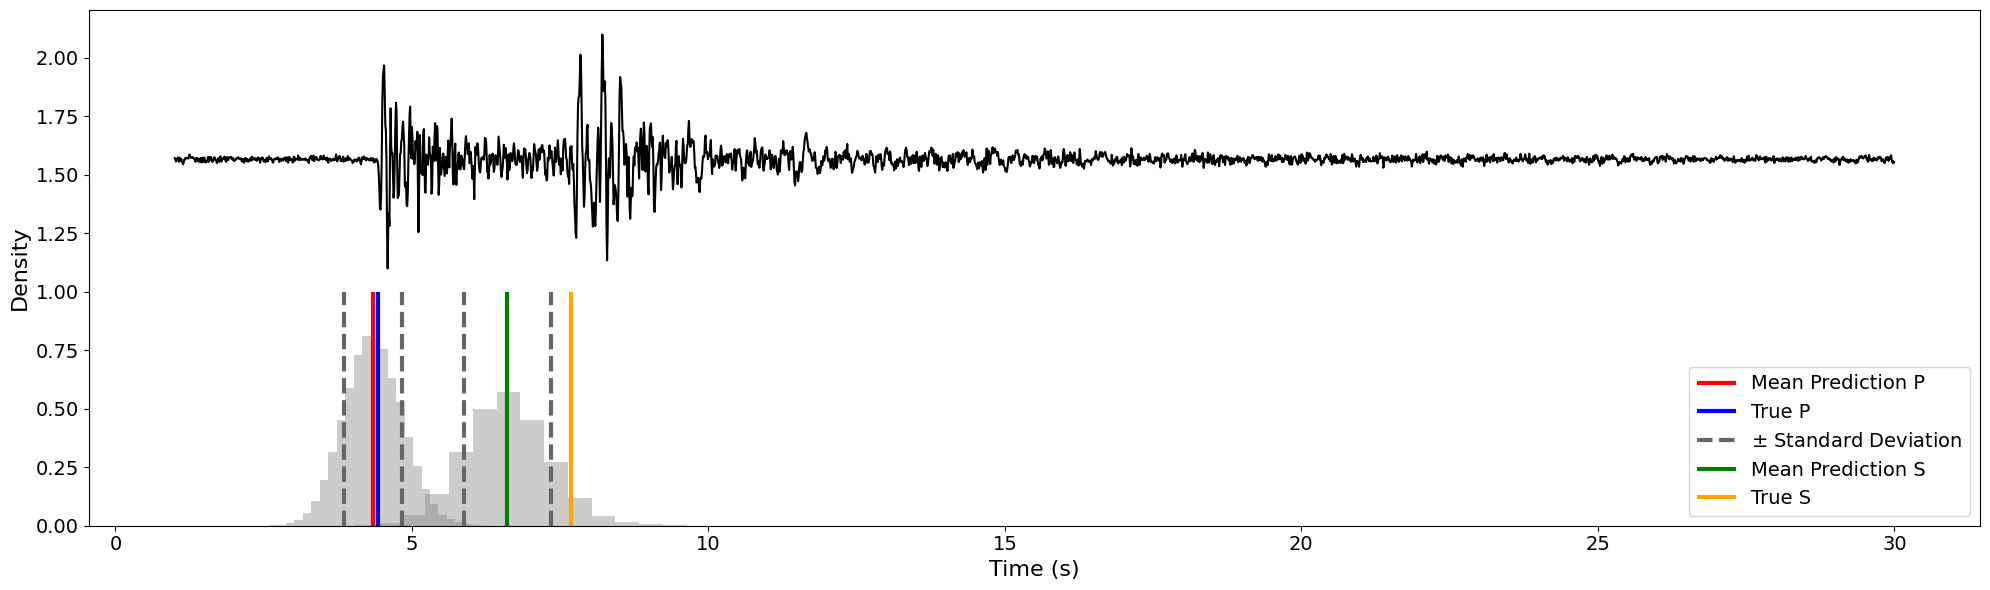

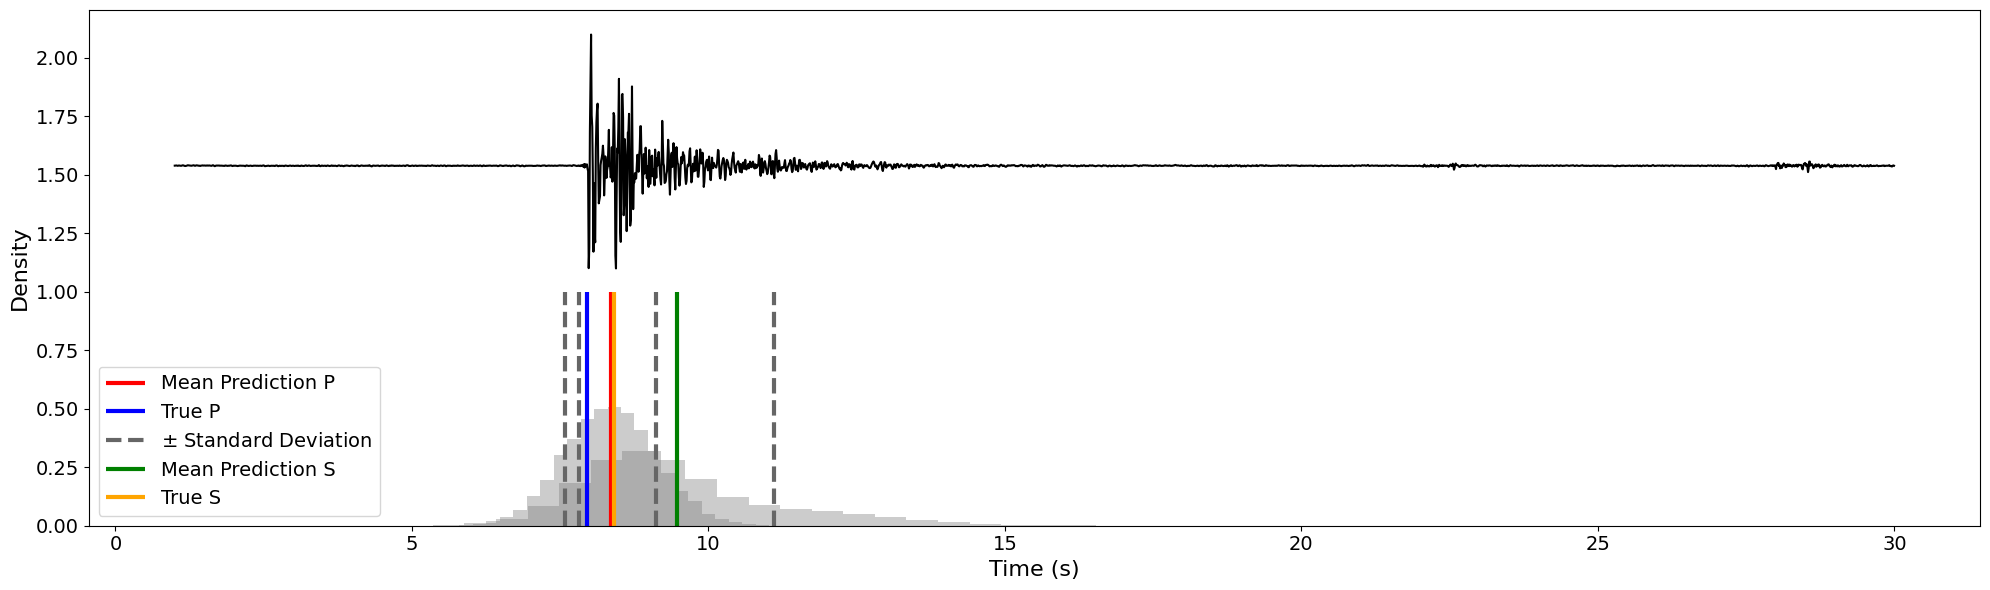

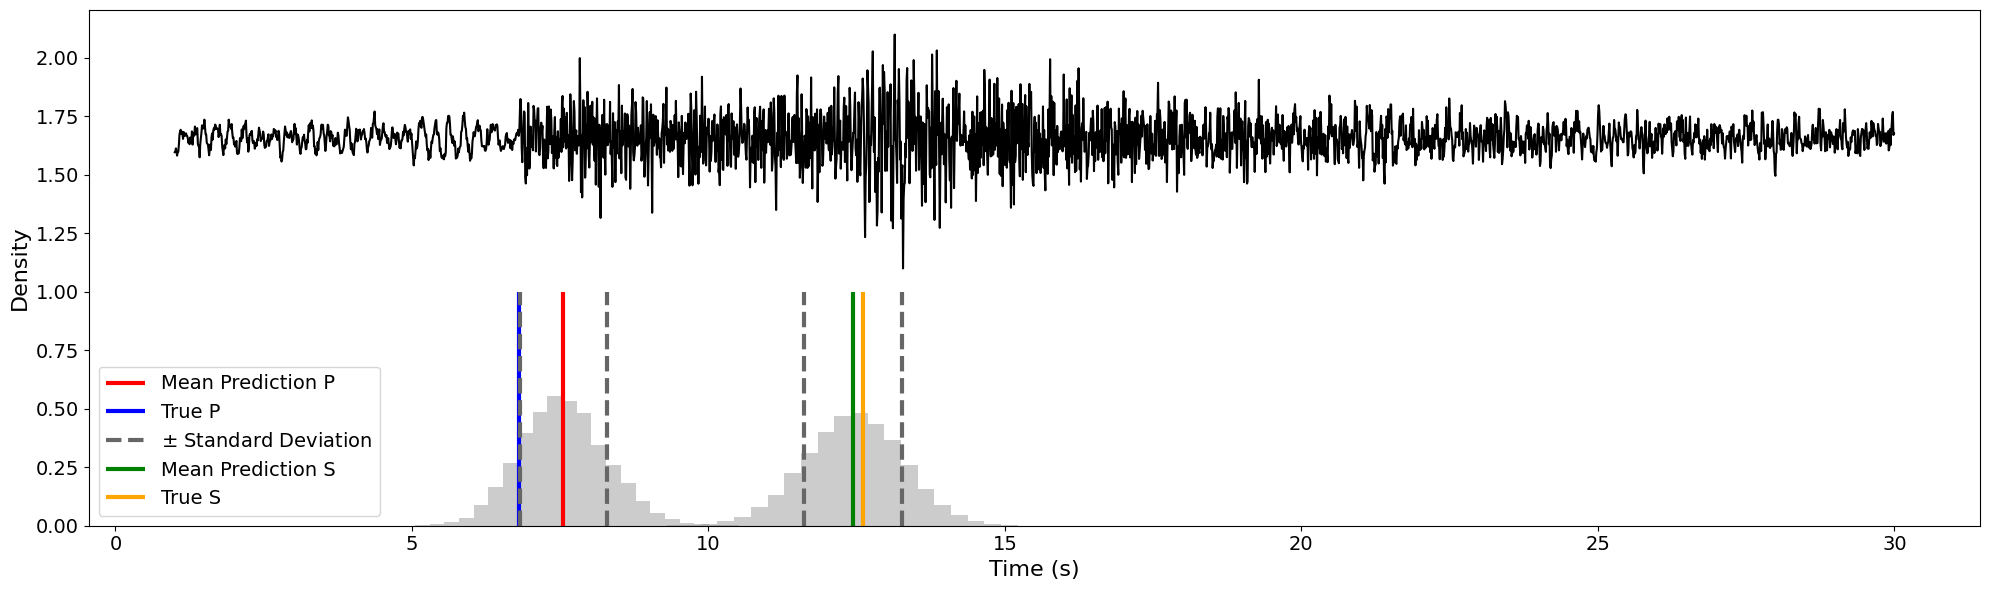

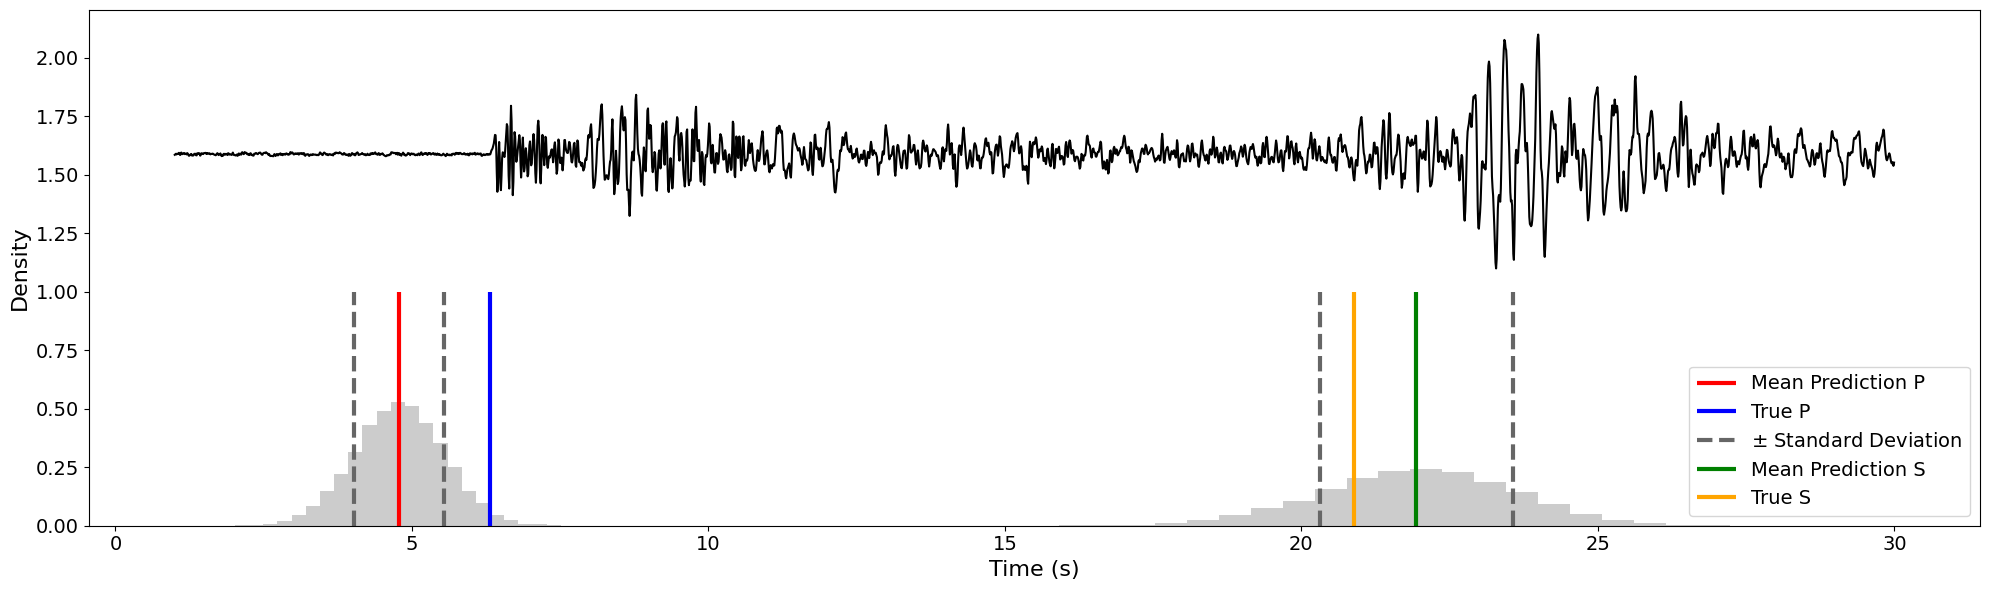

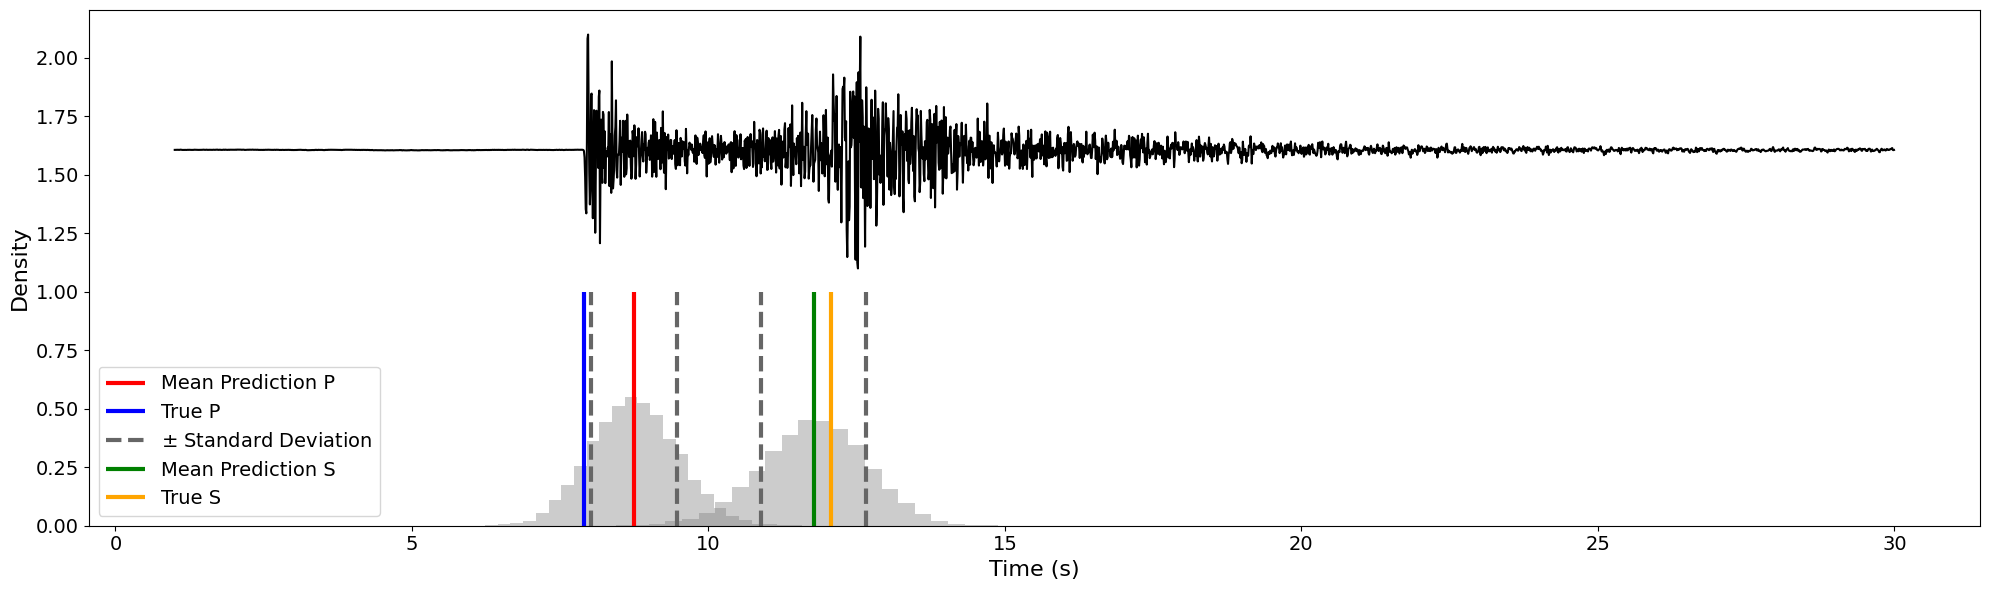

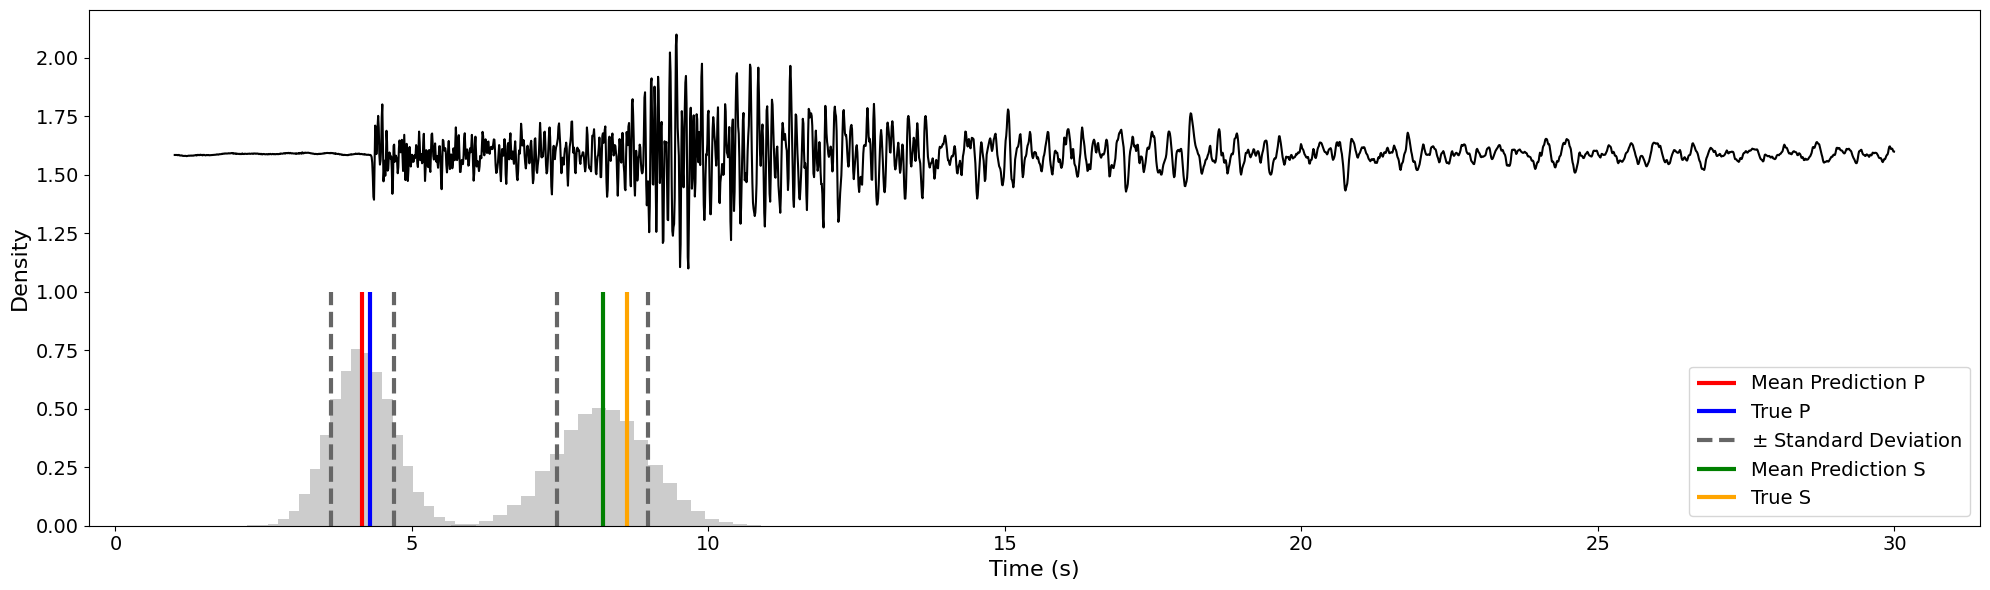

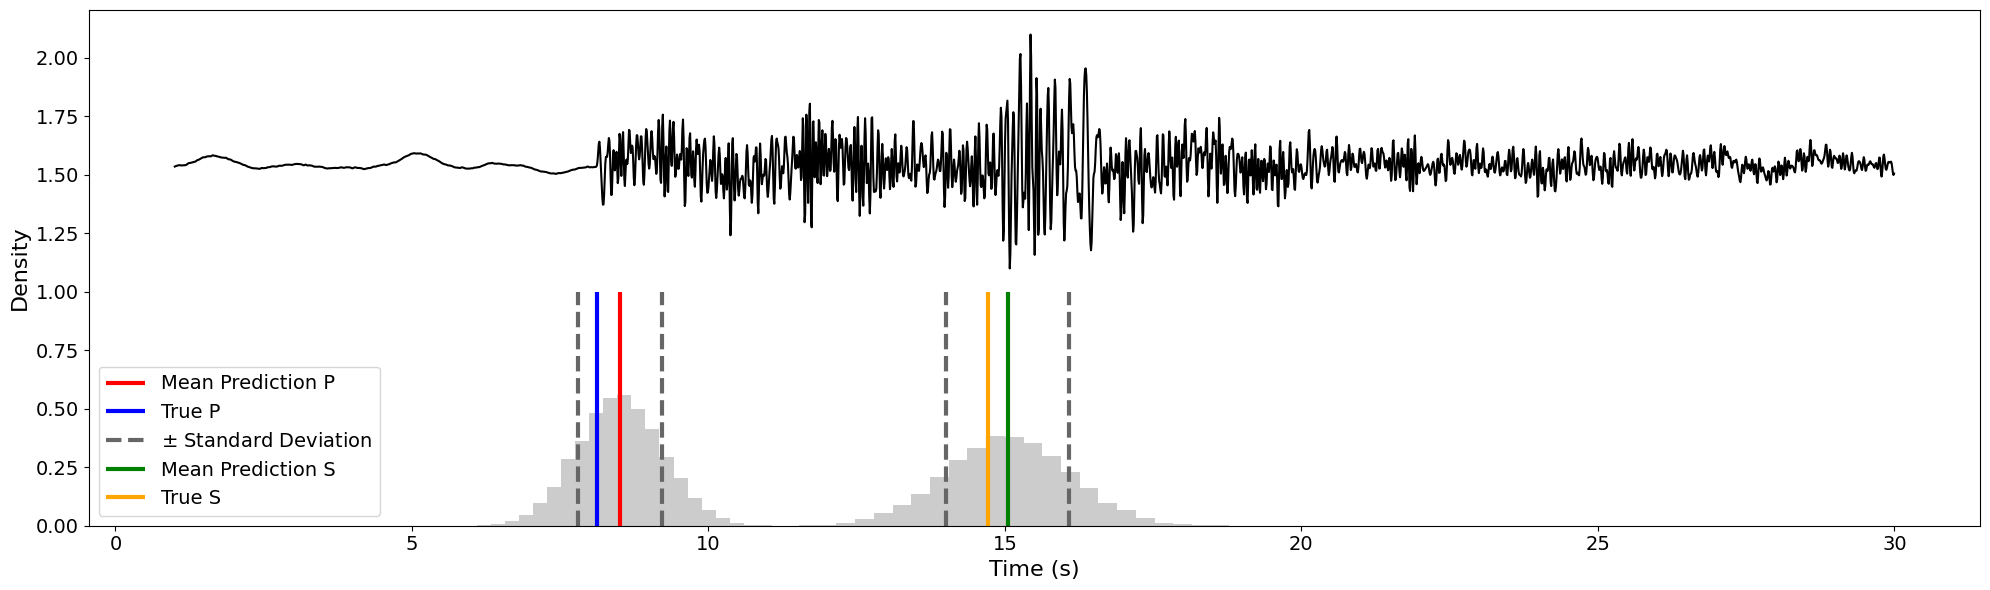

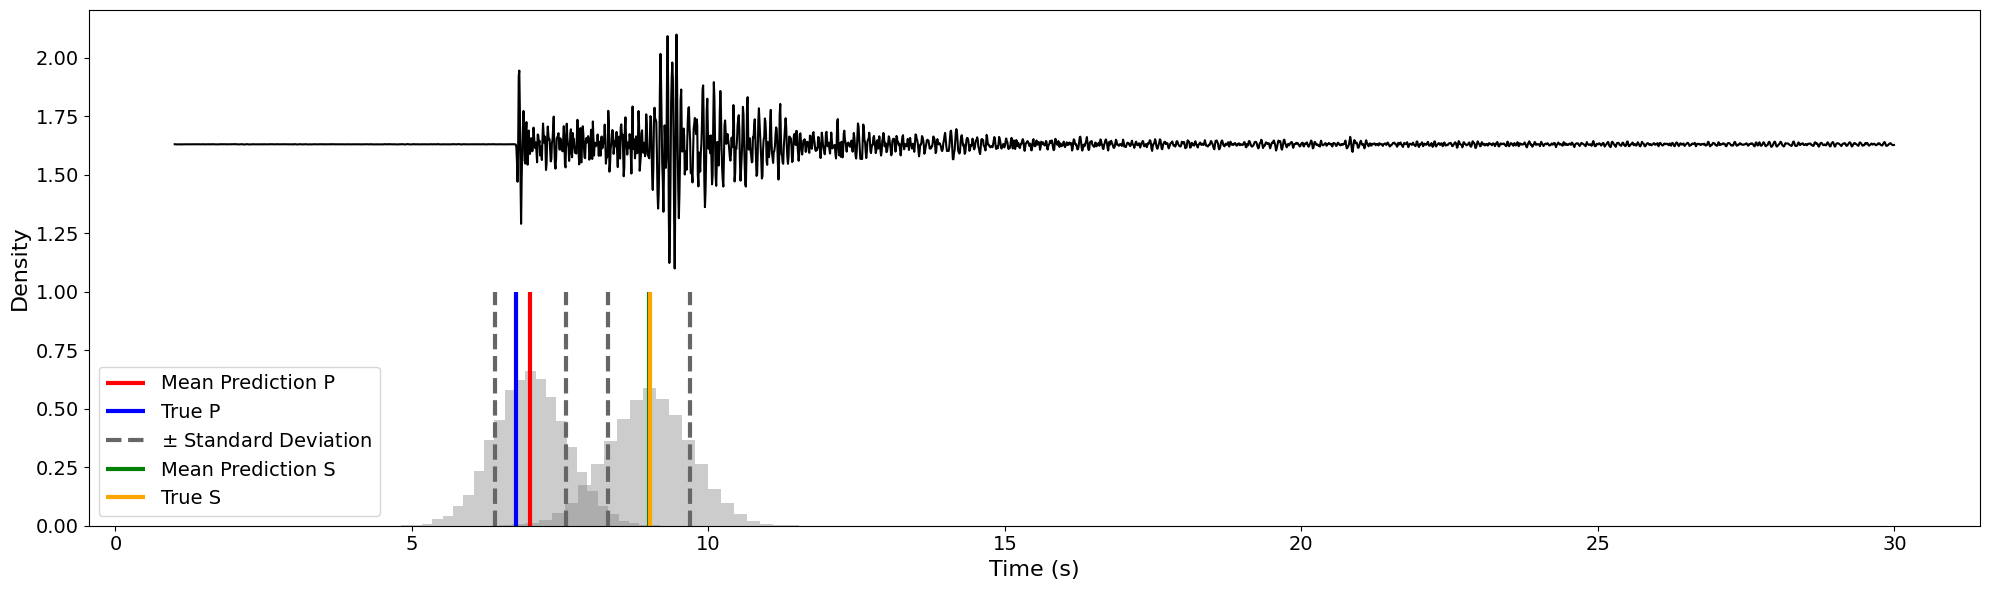

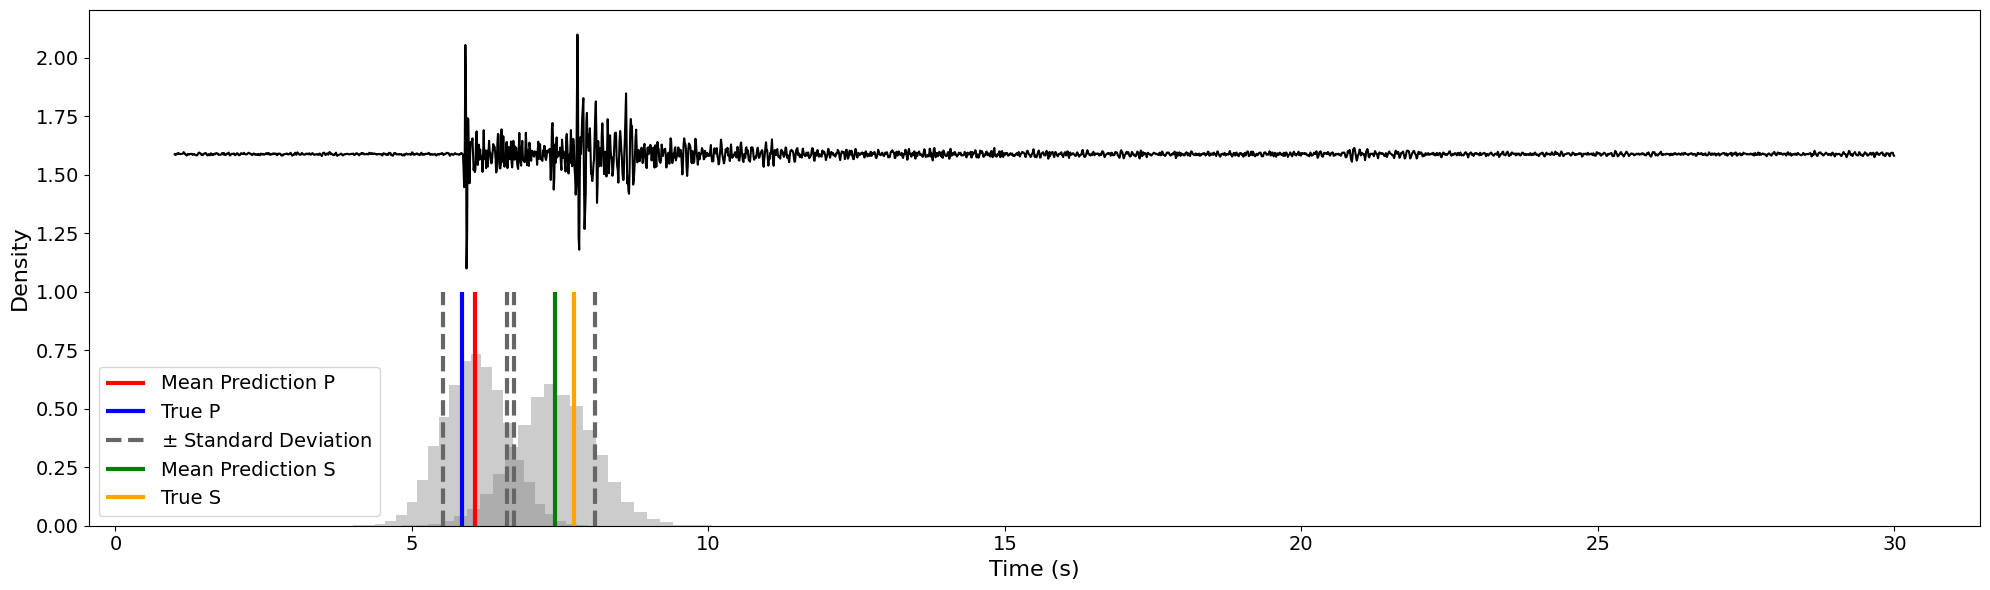

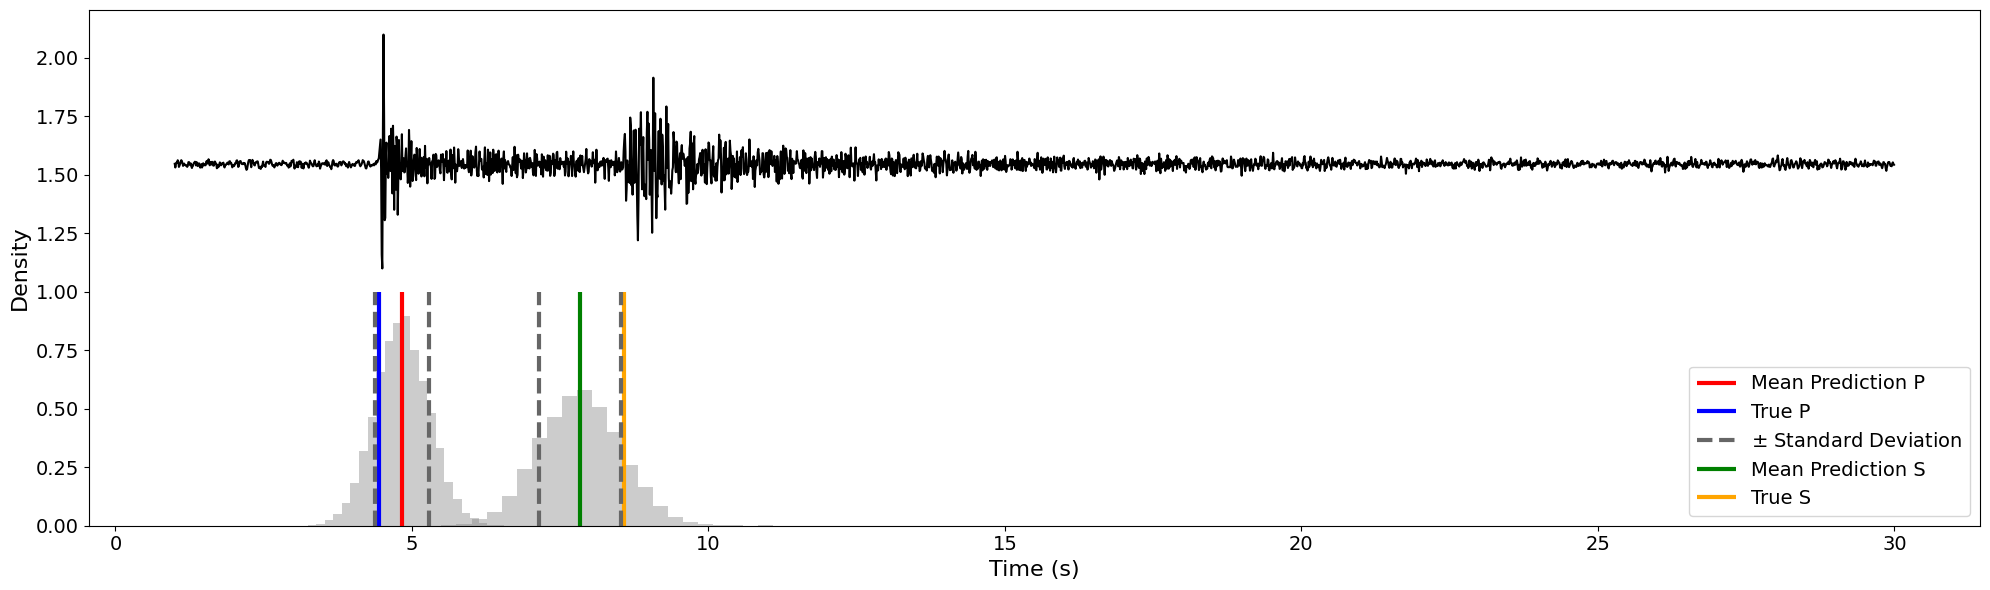

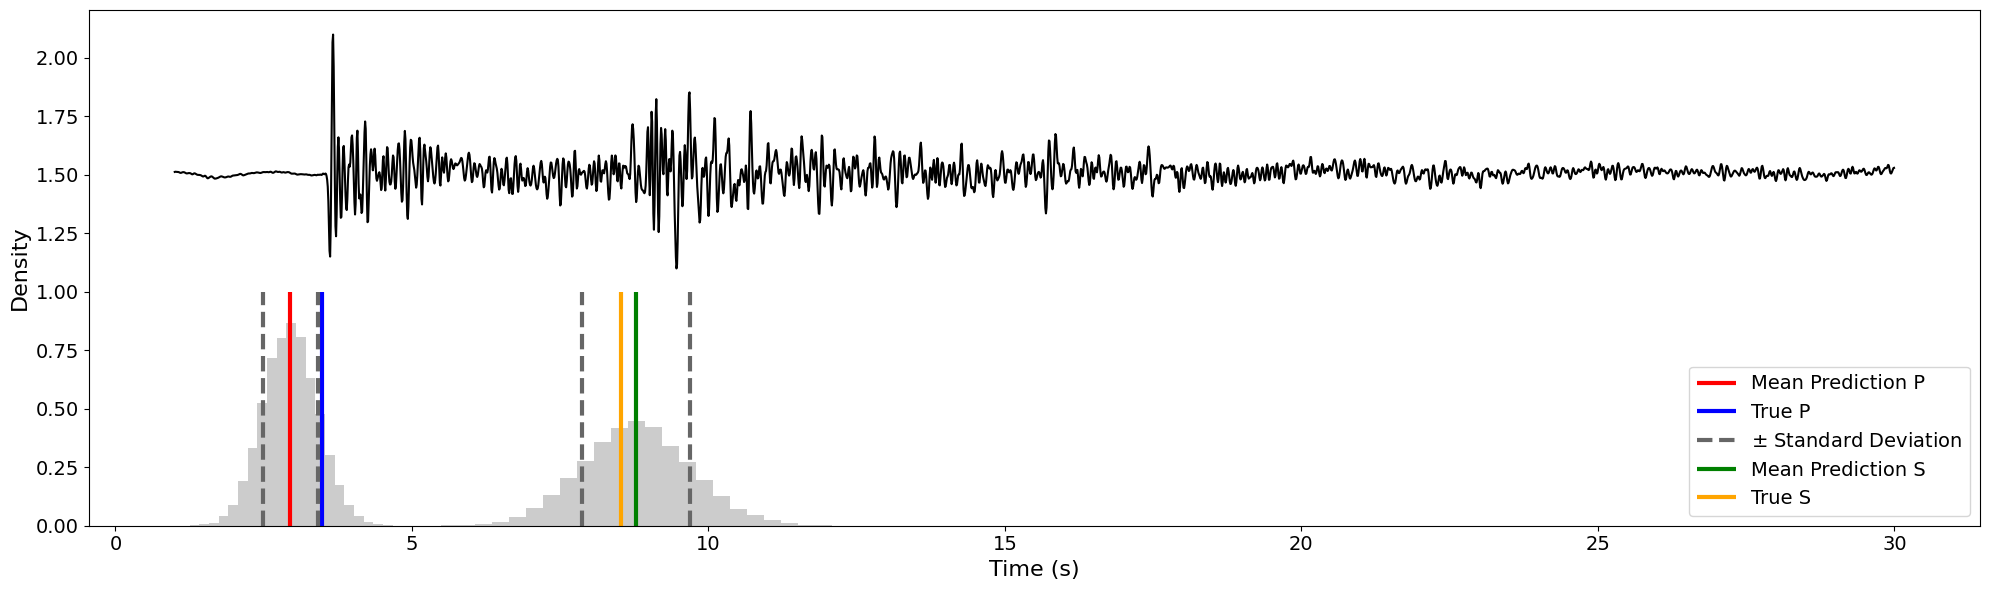

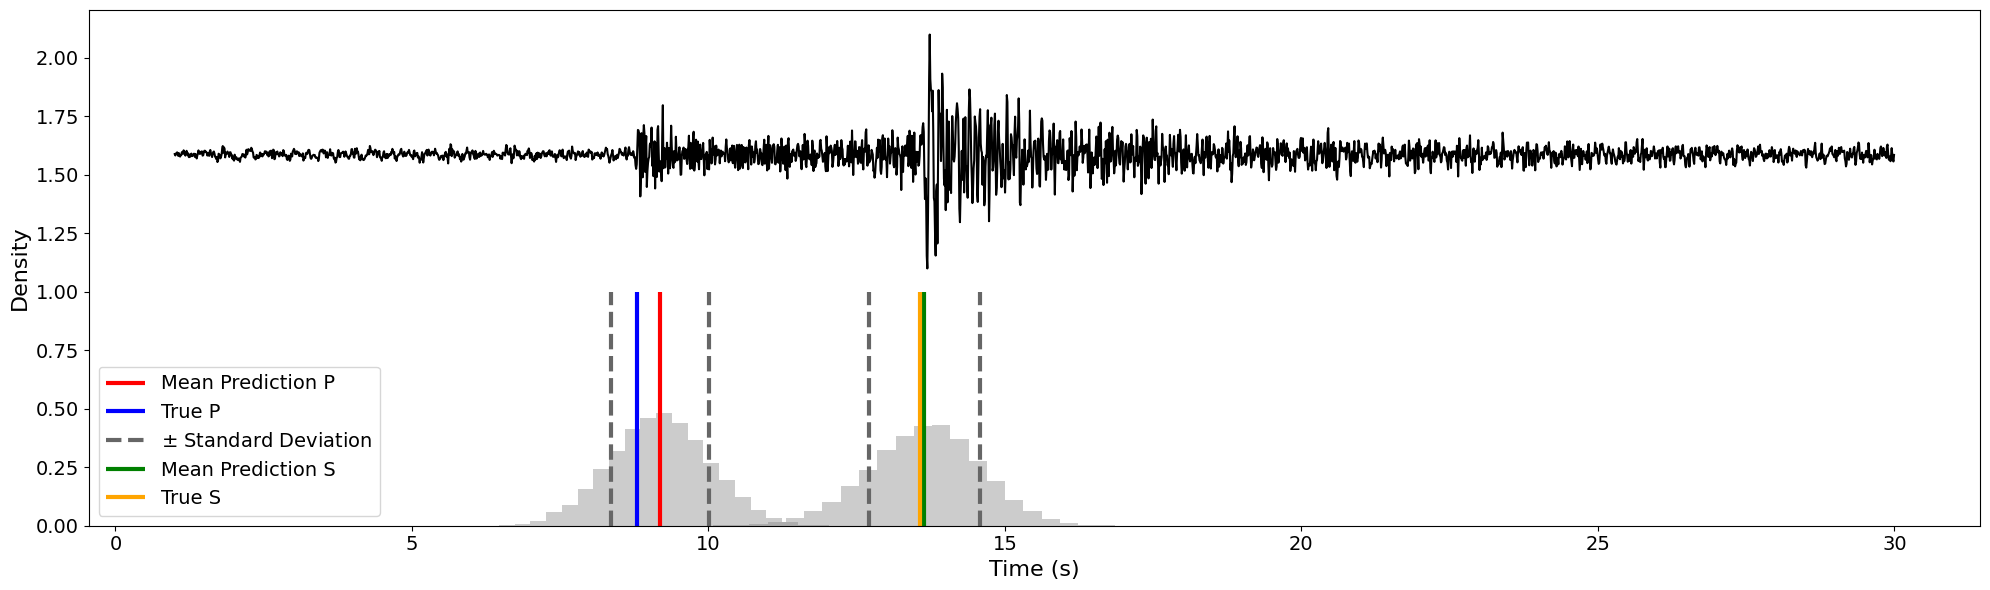

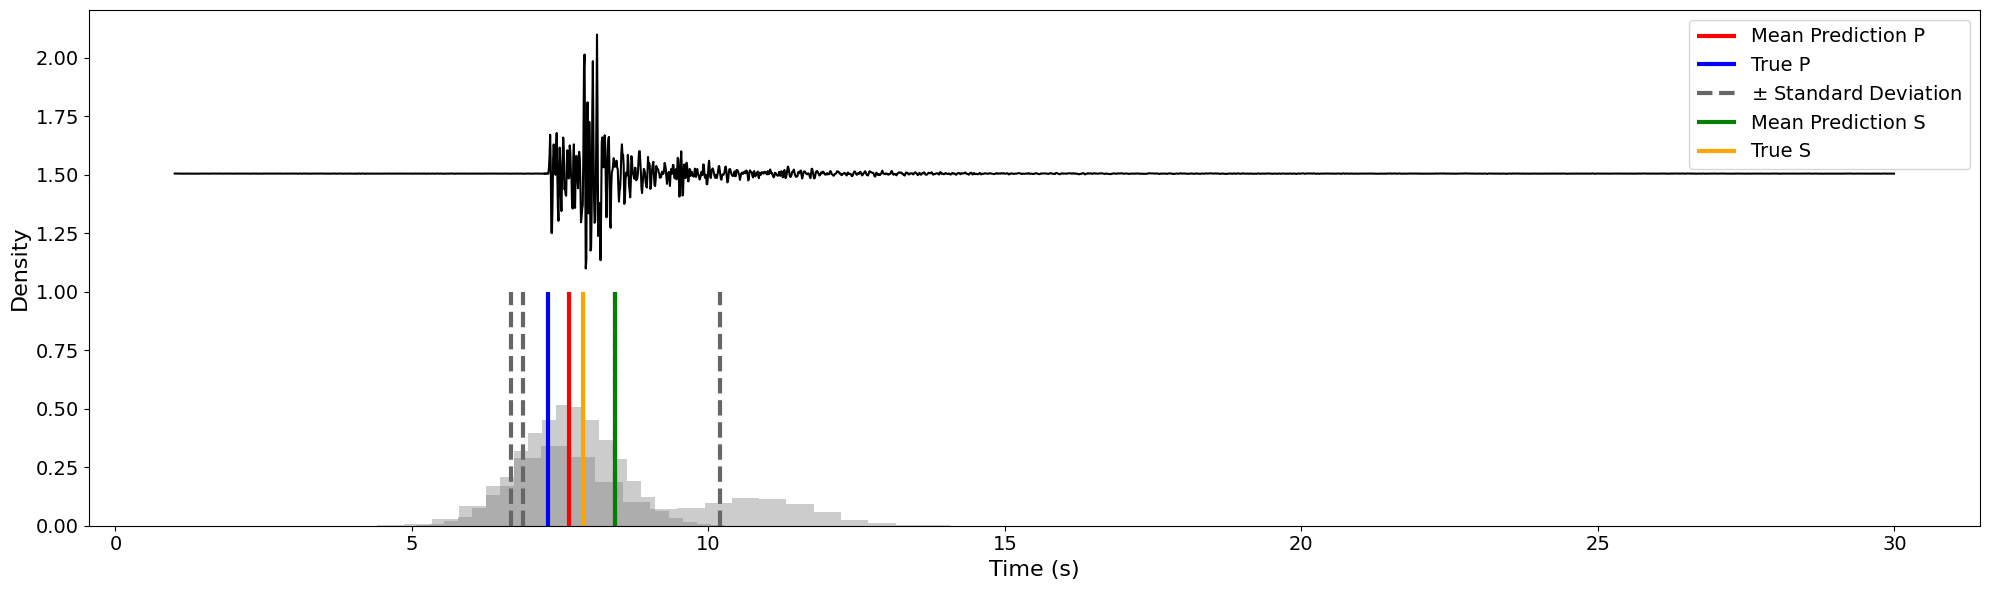

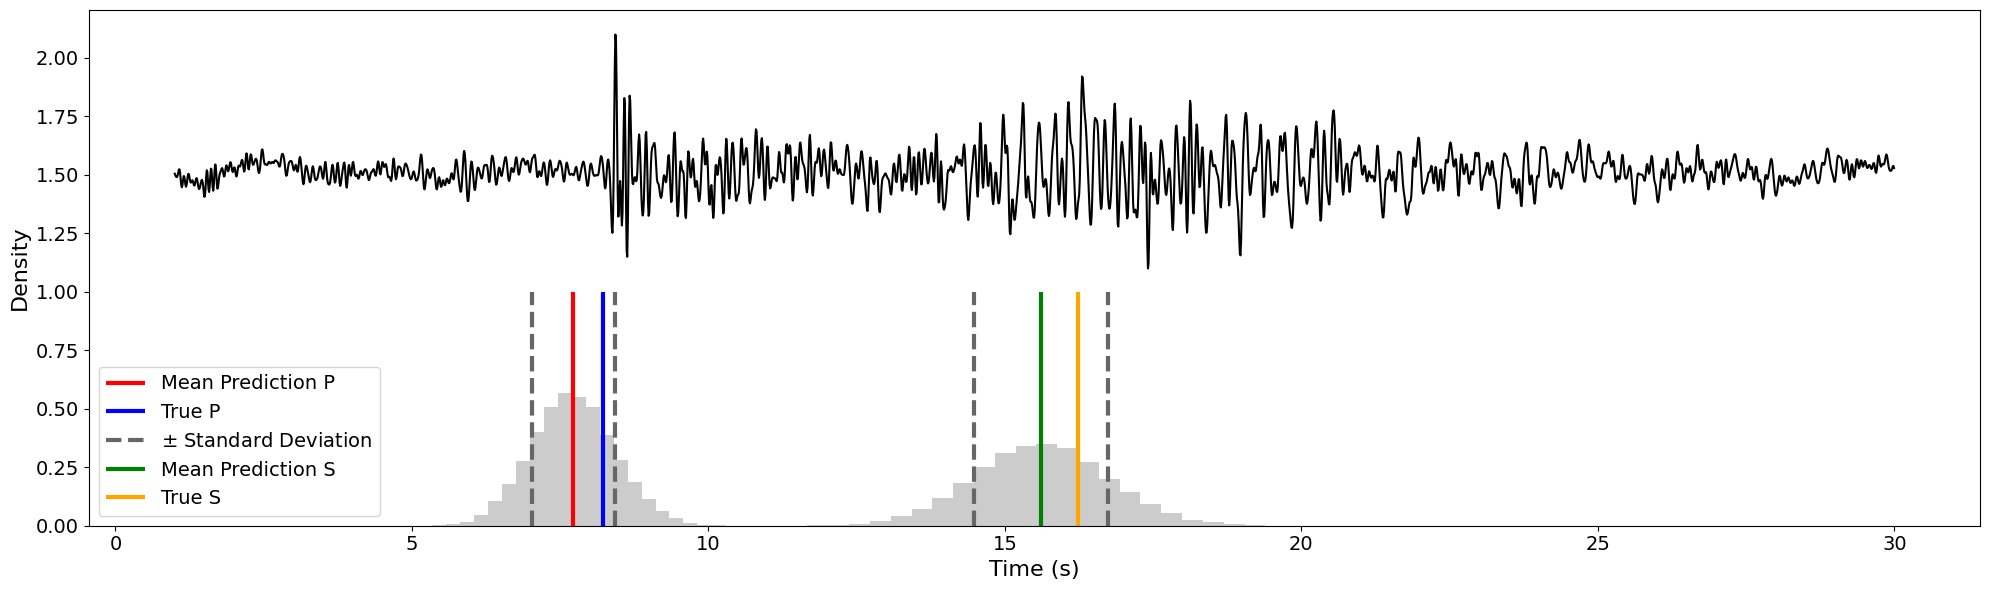

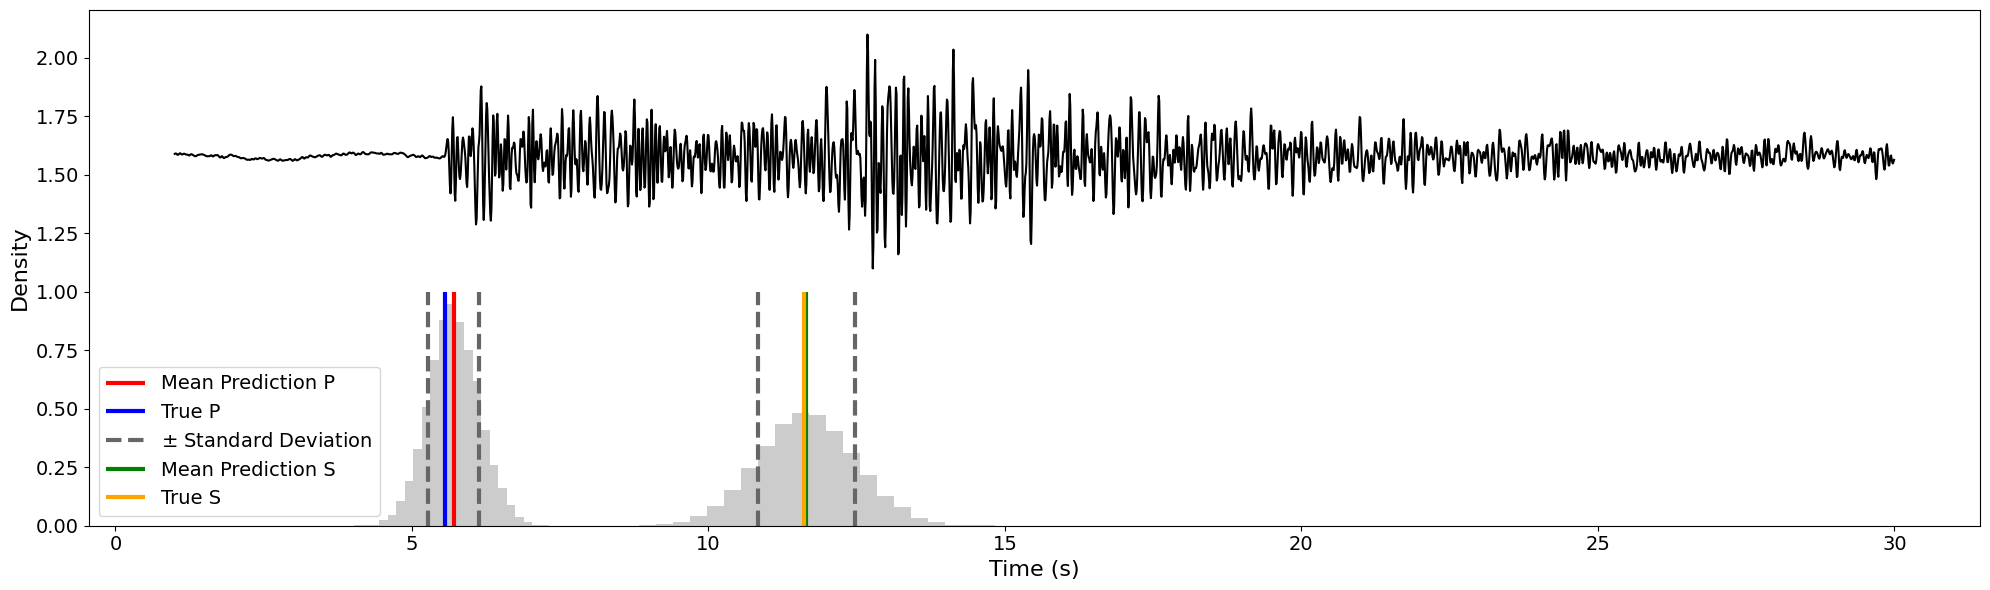

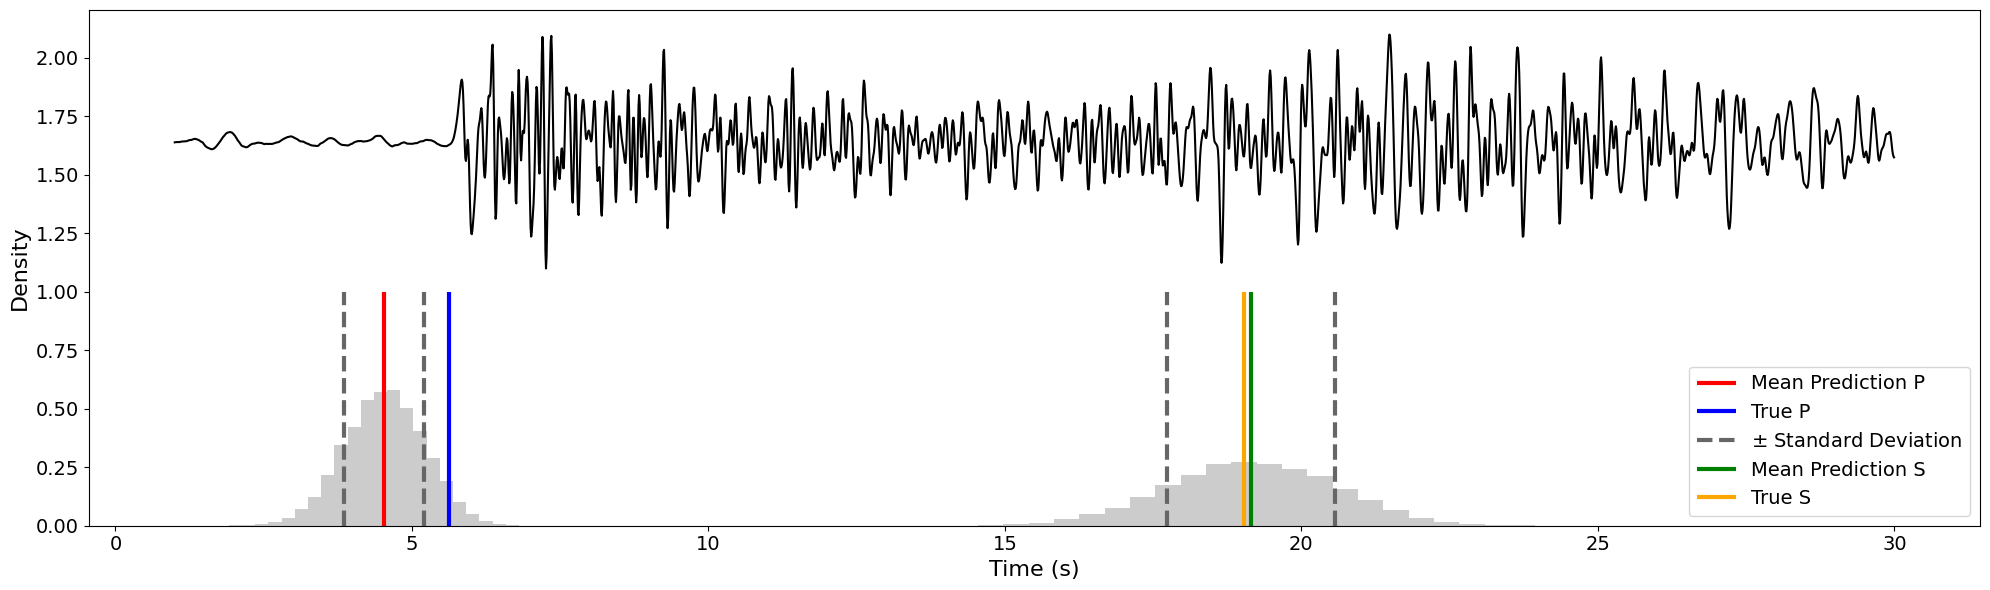

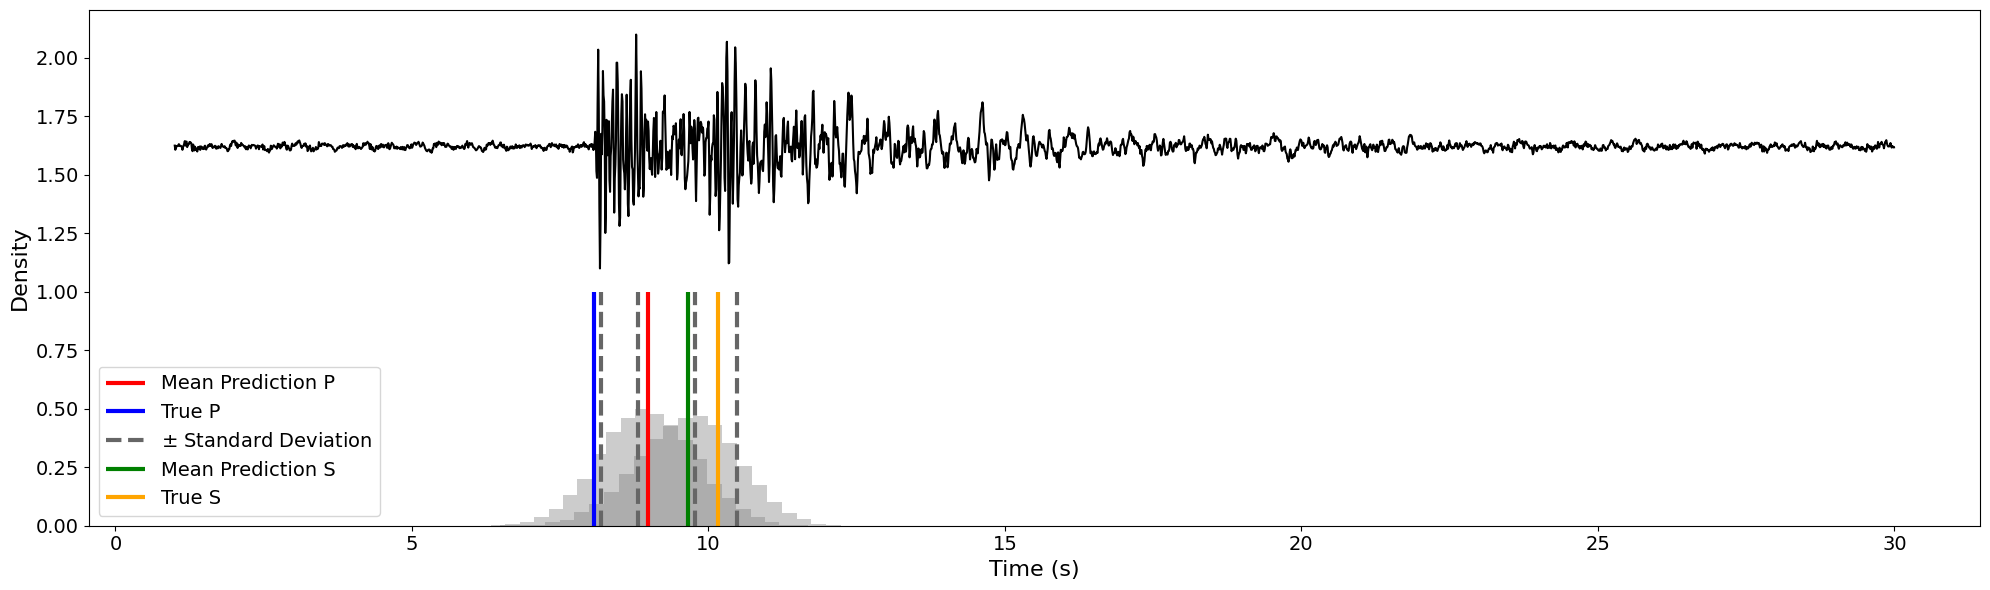

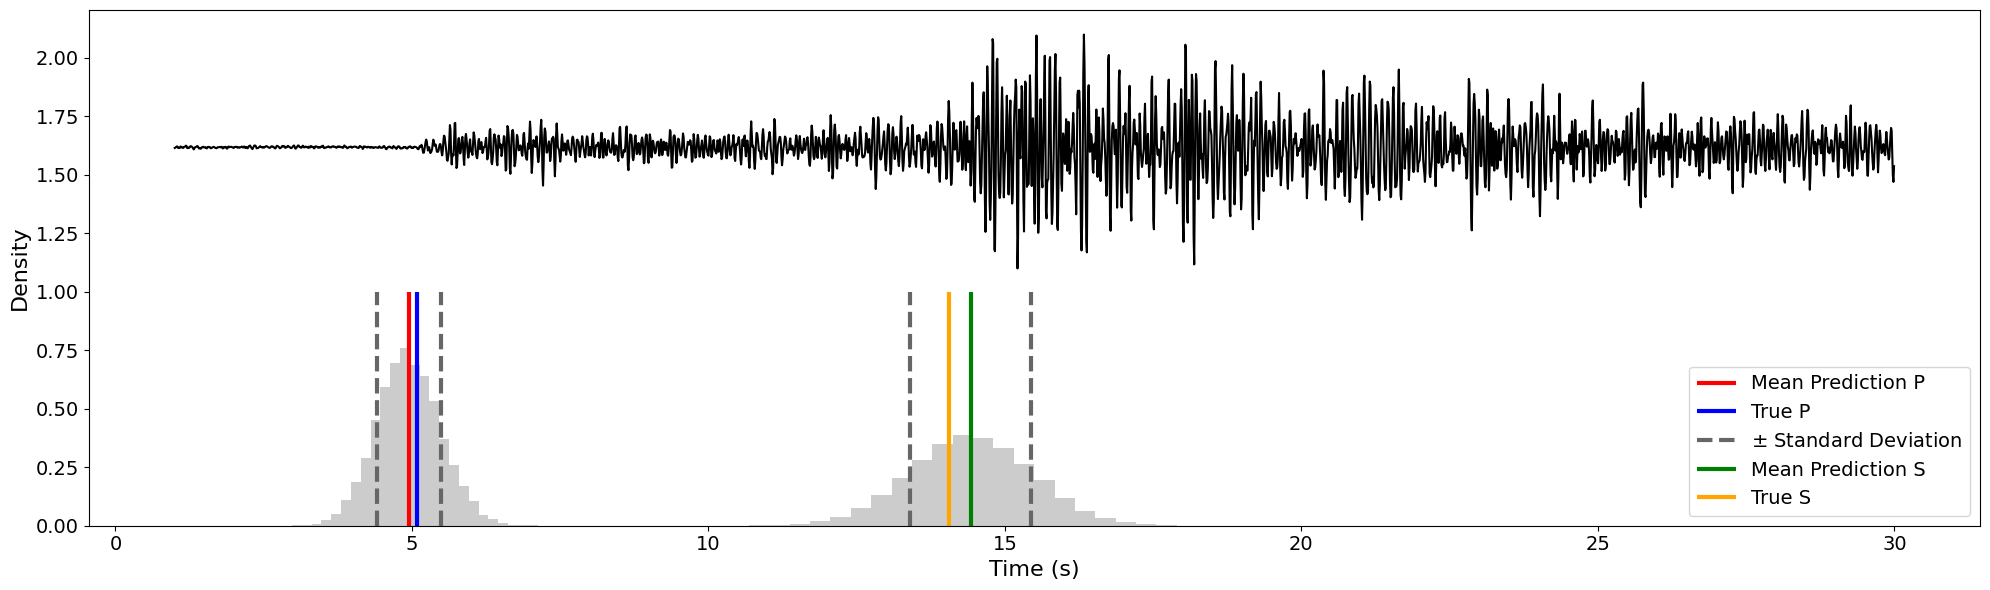

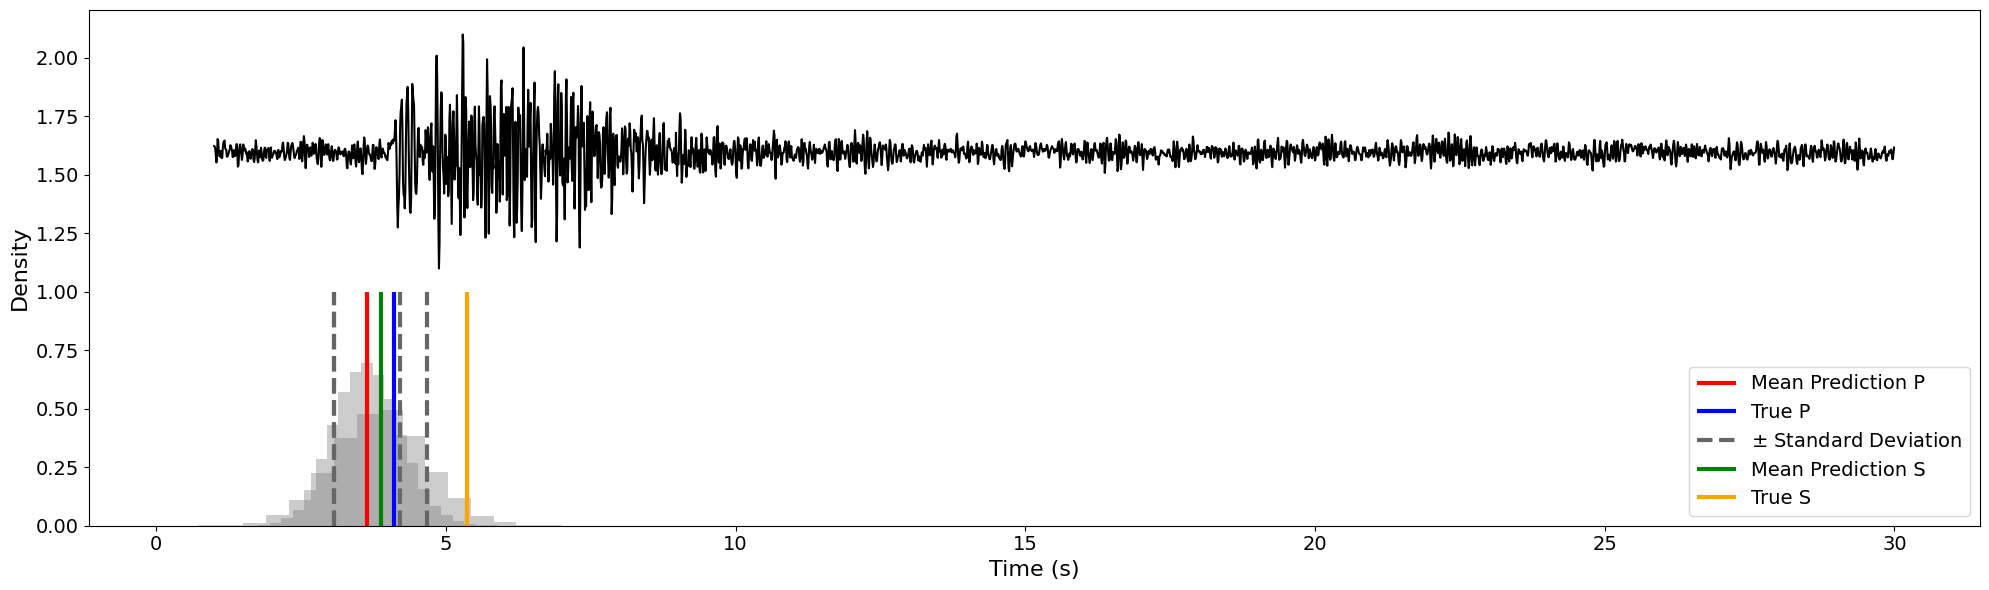

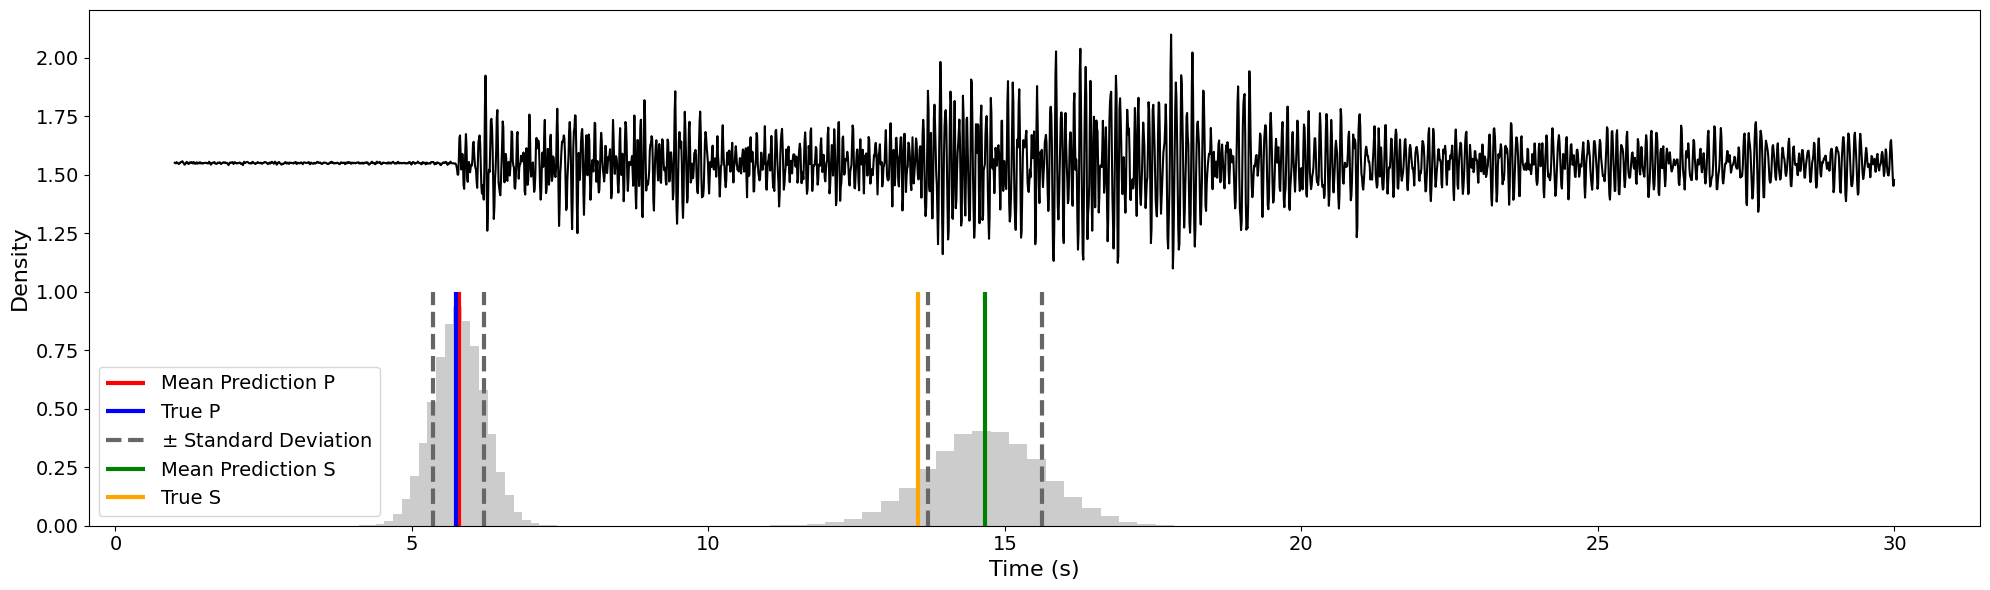

In [185]:
x = np.linspace(start=0, stop=5900, num=5900)
min = 100
max =3000

for i in range(32):
    # Creating the primary axis for the wave and vertical lines
    fig, ax1 = plt.subplots(figsize=(20, 6))

    # Plotting the wave
    ax1.plot(x[min:max]/100, waves[i,0,min:max].detach().cpu().numpy() + 1.1, 'k')
    ax1.set_xlabel('Time (s)', fontsize=16)
    ax1.set_ylabel('Density', color='k', fontsize=16)
    ax1.tick_params(axis='both', which='major', labelsize=14)

    # Plotting the vertical lines for MAP and true label
    map_value = np.mean(outs_avg[i,0,:].detach().cpu().numpy())/100
    true_label = labels[i,0].detach().cpu().numpy()/100
    ax1.vlines(map_value, ymax=1, ymin=0, colors="r", label="Mean Prediction P", linewidth=3) #linestyles="--")
    ax1.vlines(true_label, ymax=1, ymin=0, colors="b", label="True P", linewidth=3) #linestyles="--")
    stdP = np.std(outs_avg[i,0,:].detach().cpu().numpy()/100)
    ax1.vlines(map_value + stdP, ymax=1, ymin=0, colors="0.4", label="$\pm$ Standard Deviation", linewidth=3, linestyles="--")
    ax1.vlines(map_value - stdP, ymax=1, ymin=0, colors="0.4", linewidth=3, linestyles="--")


    map_value = np.mean(outs_avg[i,1,:].detach().cpu().numpy())/100 - 2
    true_label = labels[i,1].detach().cpu().numpy()/100 
    ax1.vlines(map_value, ymax=1, ymin=0, colors="g", label="Mean Prediction S",linewidth=3) #linestyles="--")
    ax1.vlines(true_label, ymax=1, ymin=0, colors="orange", label="True S", linewidth=3) #linestyles="--") 
    stdS = np.std(outs_avg[i,1,:].detach().cpu().numpy()/100 - 2)
    ax1.vlines(map_value + stdS, ymax=1, ymin=0, colors="0.4", linewidth=3, linestyles="--")
    ax1.vlines(map_value - stdS, ymax=1, ymin=0, colors="0.4", linewidth=3, linestyles="--")
    
    # Creating a secondary axis for the Den

    # Generating Gaussian data points centered at out[i,0] with a std deviation of 0.007
    #gaussian_data = np.random.normal(map_value, 5, 100000)

    # Plotting the histogram of the Gaussian data as a density plot
    #ax2.hist(gaussian_data, bins=25, alpha=0.5, color='gray', density=True)
    ax1.hist(outs_avg[i,0,:]/100, bins=25, alpha=0.4, color='gray', density=True)
    ax1.hist(outs_avg[i,1,:]/100 - 2, bins=25, alpha=0.4, color='gray', density=True)
    #ax2.set_ylabel('Density', color='k')


    # Adding legend and showing the plot
    ax1.legend(fontsize=14)
    fig.tight_layout()
    plt.show()

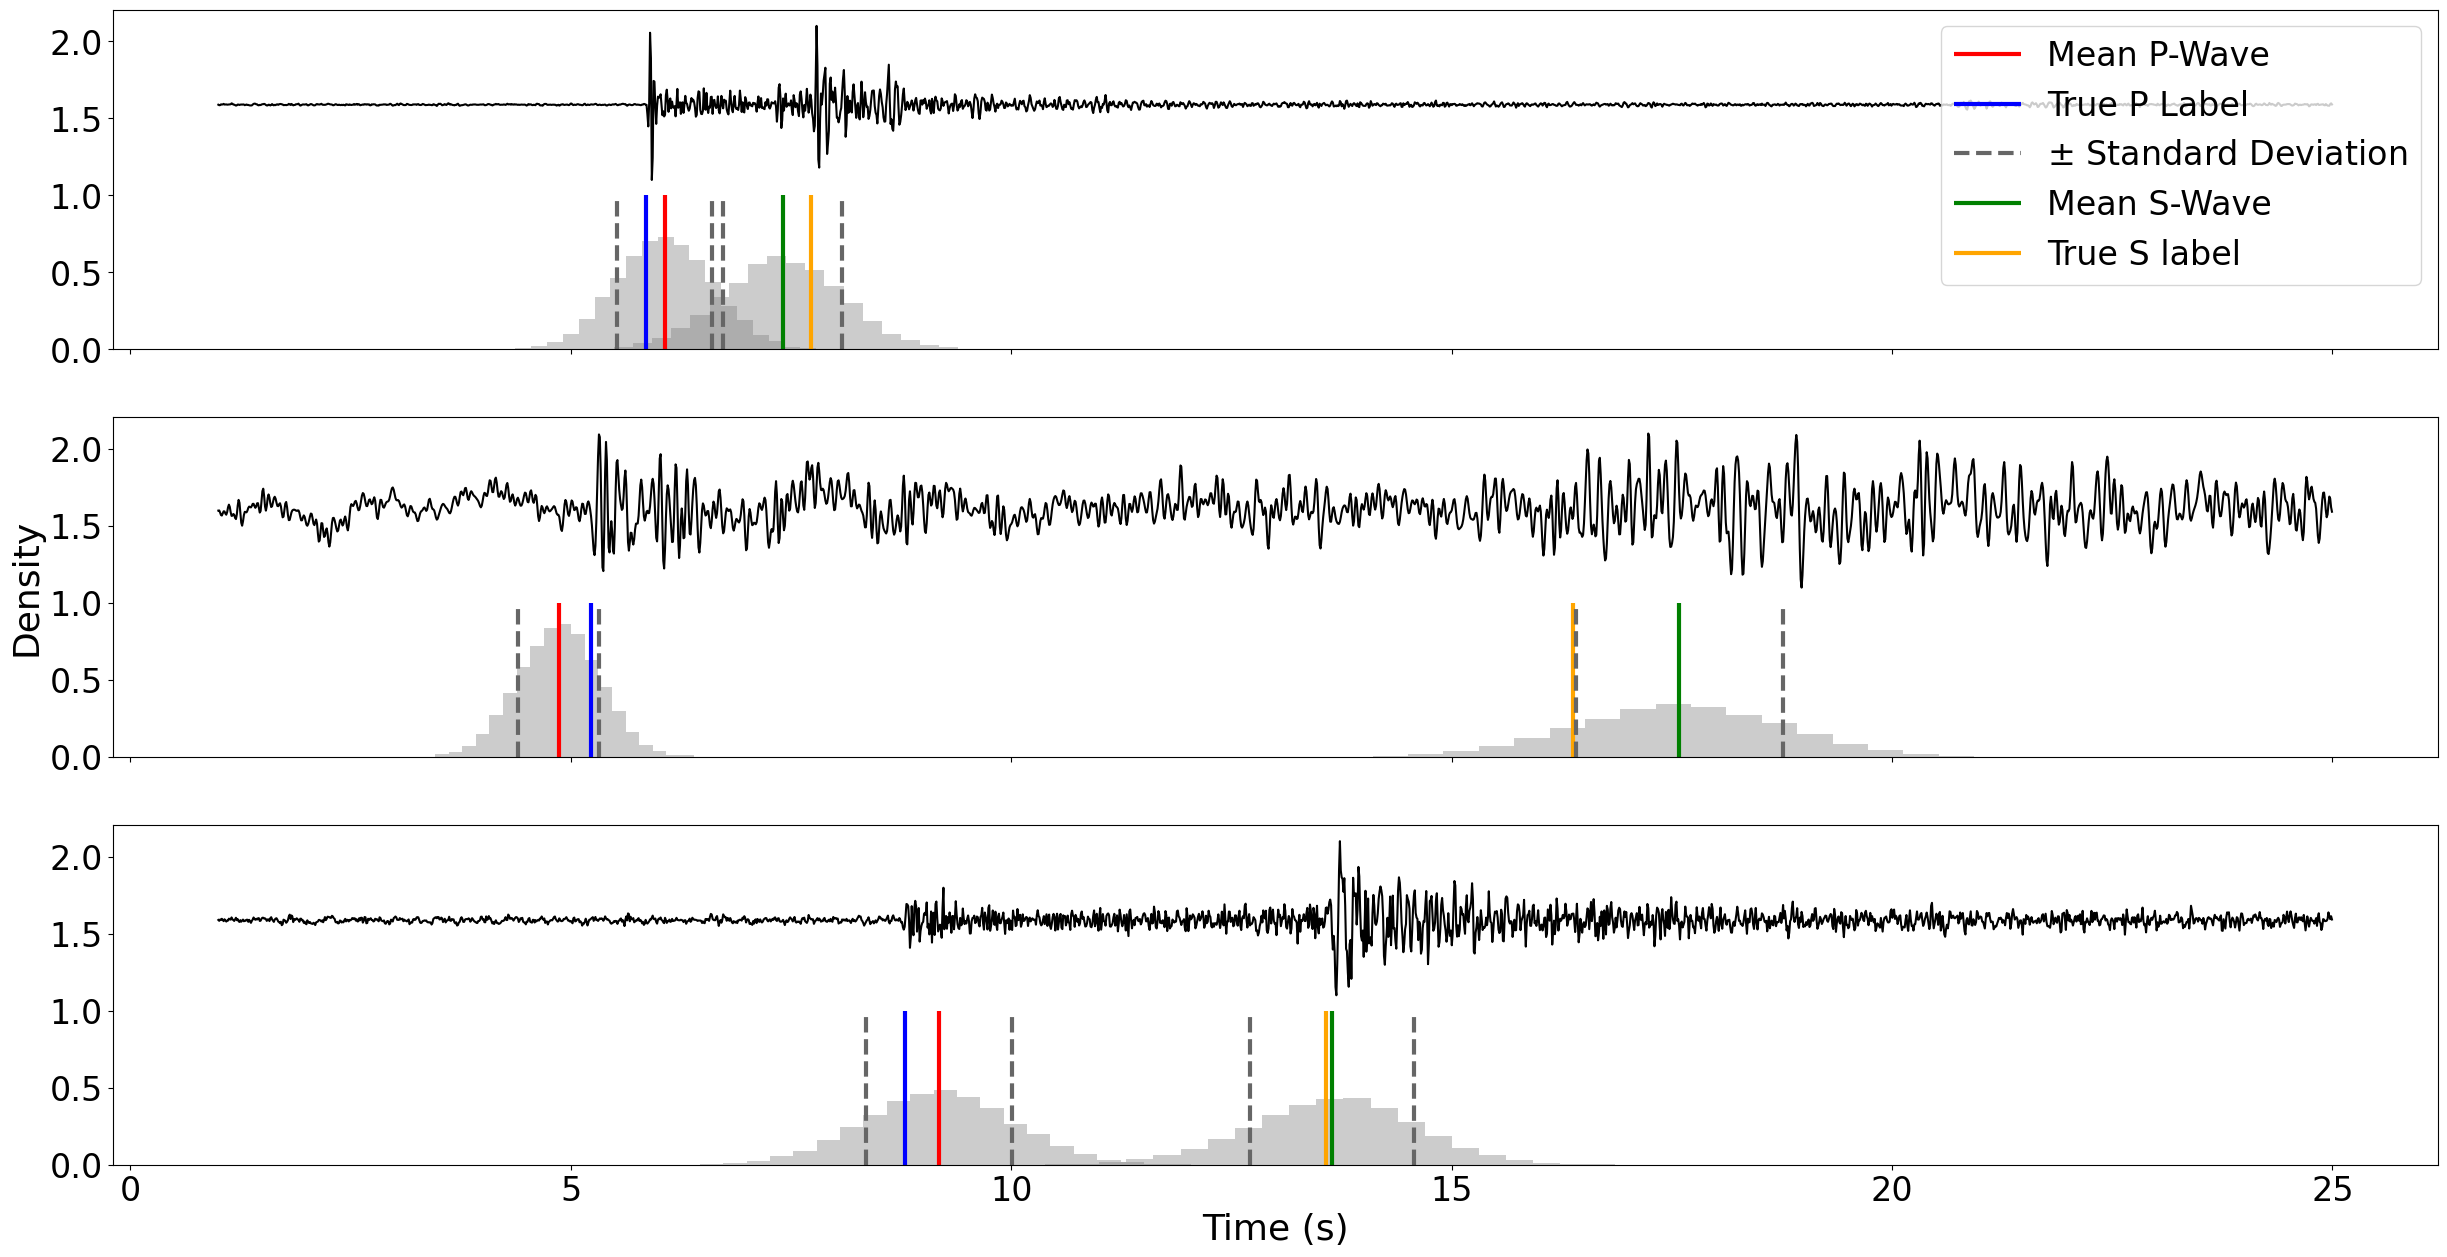

In [211]:
np.random.seed(2)  # For reproducibility
min_val = 100
max_val =2500
sample_indices = np.random.choice(range(waves.shape[0]), 3, replace=False)
wavesnp = waves.detach().cpu().numpy()
outs_avgnp = outs_avg.detach().cpu().numpy()

# Creating one plot with 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(30, 15), sharex=True)

c = 0

for idx, ax in zip(sample_indices, axs):
    # Plotting the wave
    ax.plot(x[min_val:max_val]/100, wavesnp[idx, 0, min_val:max_val] + 1.1, 'k')
    if c == 2: ax.set_xlabel('Time (s)', fontsize=26)
    if c==1: ax.set_ylabel('Density', fontsize=26)
    ax.tick_params(axis='both', which='major', labelsize=24)

    # Plotting the vertical lines for MAP and true label
    map_value = np.mean(outs_avgnp[idx, 0, :])/100
    true_label = labels[idx, 0].cpu()/100
    stdP = np.std(outs_avgnp[idx, 0, :]/100)
    ax.vlines(map_value, ymax=1, ymin=0, colors="r", label="Mean P-Wave", linewidth=3)
    ax.vlines(true_label, ymax=1, ymin=0, colors="b", label="True P Label", linewidth=3)
    ax.vlines([map_value + stdP, map_value - stdP], ymax=1, ymin=0, colors="0.4", label="$\pm$ Standard Deviation", linewidth=3, linestyles="--")

    map_value = np.mean(outs_avgnp[idx, 1, :])/100 - 2
    true_label = labels[idx, 1].cpu()/100
    stdS = np.std(outs_avgnp[idx, 1, :]/100 - 2)
    ax.vlines(map_value, ymax=1, ymin=0, colors="g", label="Mean S-Wave", linewidth=3)
    ax.vlines(true_label, ymax=1, ymin=0, colors="orange", label="True S label", linewidth=3)
    ax.vlines([map_value + stdS, map_value - stdS], ymax=1, ymin=0, colors="0.4", linewidth=3, linestyles="--")

    # Plotting the histogram
    ax.hist(outs_avgnp[idx, 0, :]/100, bins=25, alpha=0.4, color='gray', density=True)
    ax.hist(outs_avgnp[idx, 1, :]/100 - 2, bins=25, alpha=0.4, color='gray', density=True)

    # Adding legend
    if c == 0: ax.legend(fontsize=24)
    c += 1

# Adjusting layout
plt.savefig("DropOutResult.png")
plt.show()

In [8]:
out.shape

torch.Size([32, 2])

In [182]:
model.train()
model.to(device)
outs_avg = torch.zeros(32,2,20000)
for i in range(20000):
    new_out = model(waves).detach().cpu()
    outs_avg[:,:,i] =new_out

(array([  16.,  194., 1444., 4838., 8992., 8564., 4448., 1289.,  200.,
          15.]),
 array([ 599.39593506,  667.65246582,  735.90899658,  804.16552734,
         872.42205811,  940.67858887, 1008.93518066, 1077.19165039,
        1145.44824219, 1213.70471191, 1281.96130371]),
 <BarContainer object of 10 artists>)

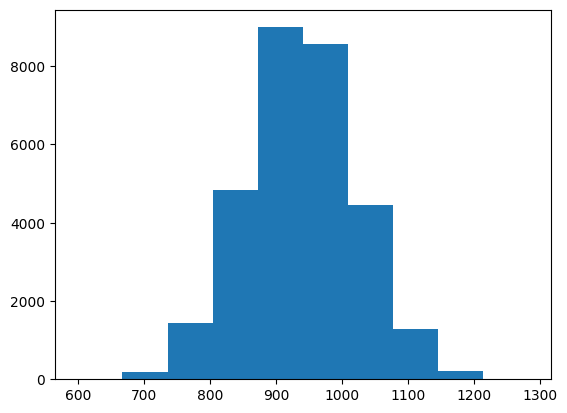

In [55]:
plt.hist(outs_avg[11,0,:])

In [10]:
#conda env config vars set PYTORCH_ENABLE_MPS_FALLBACK=1

To make your changes take effect please reactivate your environment

Note: you may need to restart the kernel to use updated packages.


In [8]:
model.to(device)
la = Laplace(model, 'regression', subset_of_weights='last_layer', hessian_structure='kron')
la.fit(picker.test_loader)


RuntimeError: MPS backend out of memory (MPS allocated: 12.97 GB, other allocations: 4.39 GB, max allowed: 18.13 GB). Tried to allocate 1.15 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
la.optimize_prior_precision(method='marglik')

In [ ]:
pred = la(waves, link_approx='probit')

In [ ]:
pred[1].shape, pred[0].shape

(torch.Size([32, 2, 2]), torch.Size([32, 2]))

In [ ]:
pred[1][:,1,1]

tensor([6.8624e-05, 6.6584e-05, 1.8138e-04, 6.8935e-05, 1.7825e-04, 7.2950e-05,
        5.3135e-05, 9.5284e-05, 2.1374e-03, 9.1652e-05, 2.1186e-04, 1.1281e-04,
        9.3876e-05, 1.0784e-04, 1.5807e-04, 5.2717e-04, 1.0681e-04, 8.5633e-05,
        1.3435e-04, 2.6609e-04, 2.2473e-04, 1.5695e-04, 7.2933e-05, 9.9896e-05,
        1.9176e-04, 8.5163e-05, 2.2176e-04, 1.4548e-04, 1.5516e-04, 9.1352e-05,
        1.0767e-04, 7.8499e-05], device='mps:0')

In [ ]:
print(pred[1][:,1,1])

tensor([6.8624e-05, 6.6584e-05, 1.8138e-04, 6.8935e-05, 1.7825e-04, 7.2950e-05,
        5.3135e-05, 9.5284e-05, 2.1374e-03, 9.1652e-05, 2.1186e-04, 1.1281e-04,
        9.3876e-05, 1.0784e-04, 1.5807e-04, 5.2717e-04, 1.0681e-04, 8.5633e-05,
        1.3435e-04, 2.6609e-04, 2.2473e-04, 1.5695e-04, 7.2933e-05, 9.9896e-05,
        1.9176e-04, 8.5163e-05, 2.2176e-04, 1.4548e-04, 1.5516e-04, 9.1352e-05,
        1.0767e-04, 7.8499e-05], device='mps:0')
